# Outline

This notebook contains code for testing/profiling the usage of a convolutional neural network (CNN) architecture for predicting the genomic locations of TSSes in the E. coli K-12 MG1655 genome

# Import Packages

In [21]:
# built-in
from collections import Counter
from pathlib import Path
import sys

# third-party (install required)
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from shap.plots.colors import red_transparent_blue
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tensorflow.keras import backend as K

# local modules
sys.path.append('../../bitome2')

from bitome.core import Bitome

# define paths
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# Construct K-12 MG1655 Bitome

In [2]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [3]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Construct TSS Datasets

We have a few different sources of known TSS information:
- TSS annotated by RegulonDB (these will be populated in 'tss' column of TU table)
- high-throughput TSS profiling from BK Cho
- high-throughput TSS profiling from RegulonDB

## RegulonDB

In [4]:
regulondb_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()][['name', 'strand', 'tss', 'sigma_factor']]
regulondb_tss.head()

,name,strand,tss,sigma_factor
locus_tag,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70


### Sigma Factor Specific

In [5]:
sigmas = [sig for sig in mg1655.tu_table['sigma_factor'].dropna().unique() if ',' not in sig]

sigma_tss_dfs = {}
for sigma in sigmas:
    sigma_tss_dfs[sigma] = regulondb_tss[
        (regulondb_tss['sigma_factor'].notna()) & 
        (regulondb_tss['sigma_factor'].str.contains(sigma))
    ]

## RegulonDB (HT)

In [6]:
regulondb_tss_ht = mg1655.tss_table[mg1655.tss_table['tss'].notna()][['name', 'strand', 'tss', 'sigma_factor']]
regulondb_tss_ht.head()

,name,strand,tss,sigma_factor
locus_tag,,,,
ECK120009842,galRp,1.0,2976569.0,Sigma70
ECK120009843,lpxLp,-1.0,1116709.0,NaN
ECK120009844,yceAp,1.0,1116772.0,NaN
ECK120009845,mraZp,1.0,89596.0,Sigma70
ECK120009846,sohBp1,1.0,1329284.0,"Sigma70, Sigma38"


## Cho (HT)

In [7]:
cho_tss = pd.read_csv('../data/bitome2/mg1655/tss_reads_cho_s4.csv')
cho_tss = cho_tss[['tss_id', 'strand', 'tss']]
cho_tss = cho_tss.rename(columns={'tss_id': 'name'})
cho_tss['strand'] = cho_tss['strand'].apply(lambda strand_str: 1 if strand_str == 'FWD' else -1)
cho_tss.head()

,name,strand,tss
0,TSS-FWD-1,1,148
1,TSS-FWD-2,1,163
2,TSS-FWD-3,1,170
3,TSS-FWD-4,1,2688
4,TSS-FWD-5,1,5118


## Thomason[14]

Need to do some processing with this

In [ ]:
thomason_tss = pd.read_excel('../data/thomason14_tss.xlsx', sheet_name='TSS Map MasterTable', skiprows=[0, 1])

In [24]:
# select only primary and secondary TSS
thomason_tss_final = thomason_tss[(thomason_tss['Primary'] == 1) | (thomason_tss['Secondary'] == 1)]
# only conditions where the tss was "detected" (we're not too worried about conditions right now)
thomason_tss_final = thomason_tss_final[thomason_tss_final['detected'] == 1]
thomason_tss_final = thomason_tss_final.drop_duplicates(subset=['Pos', 'Strand'])
thomason_tss_final

,Pos,Strand,detCount,Condition,detected,enriched,stepHeight,stepFactor,enrichmentFactor,classCount,...,Secondary,Internal,Antisense,Automated,Manual,Putative sRNA,Putative asRNA,Comment,Sequence -50 nt upstream + TSS (51nt),Overlap with RegulonDB
2,38,+,1,LB_2.0,1,1,8.43,>100,9.63,1,...,1,0,0,1,0,0,0,NaN,NaN,X
3,113,+,3,M63_0.4,1,1,1.80,4,25.41,1,...,1,0,0,1,0,0,0,NaN,ATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTT...,NaN
9,148,+,3,M63_0.4,1,1,831.14,16.97,2.9,1,...,0,0,0,1,0,0,0,NaN,AATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATAT...,X
24,2581,+,3,M63_0.4,1,0,16.24,15.56,1.11,2,...,0,0,0,1,0,0,0,NaN,GCGTGGCGAAGGCCCGTGATGAAGGAAAAGTTTTGCGCTATGTTGG...,X
49,5147,+,2,LB_0.4,1,1,1.47,7,3.16,1,...,0,0,0,1,0,0,0,NaN,AATGACAGGGAAAAAGGAGAAATTCTCAATAAATGCGGTAACTTAG...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,4633447,+,3,M63_0.4,1,1,8.80,3.07,3.78,1,...,1,0,0,1,0,0,0,NaN,TGCTGTTTTAGCATTCAGTGTTTTTTTCTTAGTAGAGTATGTTTTA...,NaN
52268,4633500,+,1,LB_2.0,1,1,9.11,2.3,4.69,1,...,1,0,0,1,0,0,0,NaN,ACGGAAATAAAAGTATTGAGATTTTGTTCTTAATCAATATGTTATT...,NaN
52269,4633747,+,3,M63_0.4,1,1,5.70,10.5,2.08,2,...,0,0,0,1,0,0,0,NaN,AATGTCACCTGTTATGTGAGCCGGGCGAAAACCGGTGGTATTAAAG...,NaN
52299,4638395,-,3,M63_0.4,1,1,6.53,3.3,2.7,2,...,0,0,0,1,0,0,1,NaN,GCAATTACGTACTTTAGTCATGTTACGCCGATCATGTTAATTTGCA...,NaN


## TSS Overlaps

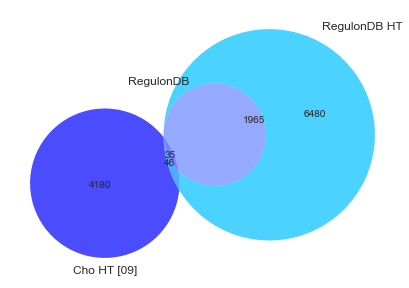

In [22]:
A = set(regulondb_tss['tss'])
B = set(regulondb_tss_ht['tss'])
C = set(thomason_tss_final['Pos'])

AB_overlap = A & B  #compute intersection of set A & set B
AC_overlap = A & C
BC_overlap = B & C
ABC_overlap = A & B & C

A_rest = A - AB_overlap - AC_overlap #see left graphic
B_rest = B - AB_overlap - BC_overlap
C_rest = C - AC_overlap - BC_overlap
        
AB_only = AB_overlap - ABC_overlap   #see right graphic
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

sets = {}               #set order A, B, C   
sets['100'] = len(A_rest)      #100 denotes A on, B off, C off
sets['010'] = len(B_rest)      #010 denotes A off, B on, C off
sets['001'] = len(C_rest)      #001 denotes A off, B off, C on
sets['110'] = len(AB_only)     #110 denotes A on, B on, C off
sets['101'] = len(AC_only)     #101 denotes A on, B off, C on
sets['011'] = len(BC_only)     #011 denotes A off, B on, C on
sets['111'] = len(ABC_overlap) #011 denotes A on, B on, C on

labels = ('RegulonDB', 'RegulonDB HT', 'Cho HT [09]')  
plt.figure(figsize=(7,7)) 
ax = plt.gca() 
venn3(subsets=sets, set_labels=labels, ax=ax,
      set_colors= ('darkviolet','deepskyblue','blue'), alpha=0.7)    
plt.show()

In [9]:
def dist_to_regdb_tss(cho_tss_row):
    cho_tss_loc, cho_tss_strand = cho_tss_row['tss'], cho_tss_row['strand']
    regdb_for_strand_df = regulondb_tss_ht[regulondb_tss_ht['strand'] == cho_tss_strand]
    min_dist = min(abs(regdb_for_strand_df['tss'] - cho_tss_loc))
    return min_dist
cho_tss['dist_to_regdb'] = cho_tss.apply(dist_to_regdb_tss, axis=1)

Text(0, 0.5, '# of Cho TSS')

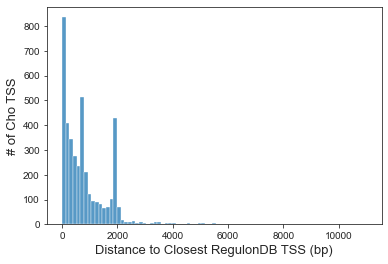

In [10]:
sns.set_style('ticks')

_, ax = plt.subplots()

sns.histplot(cho_tss['dist_to_regdb'], ax=ax)
ax.set_xlabel('Distance to Closest RegulonDB TSS (bp)', fontsize=13)
ax.set_ylabel('# of Cho TSS', fontsize=13)

## Gene/TSS Overlaps

In [11]:
genes = set(mg1655.gene_table.index)

genes_with_tss = []
genes_without_tss = []
for gene in genes:
    gene_tus = mg1655._gene_to_tus[gene]
    gene_tu_df = mg1655.tu_table.loc[gene_tus]
    gene_tu_df = gene_tu_df[gene_tu_df['tss'].notna()]
    if not gene_tu_df.empty:
        genes_with_tss.append(gene)
    else:
        genes_without_tss.append(gene)
genes_with_tss = set(genes_with_tss)

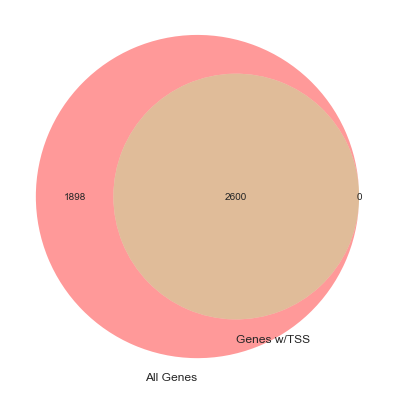

In [12]:
plt.figure(figsize=(7,7)) 
ax = plt.gca() 
venn2([genes, genes_with_tss], set_labels=('All Genes', 'Genes w/TSS'), ax=ax)
plt.show()

In [13]:
gene_table_tss_cog = mg1655.gene_table.copy()
def has_tss(gene):
    if gene in genes_with_tss:
        return 'Has TSS'
    else:
        return 'No TSS'
gene_table_tss_cog['tss'] = [has_tss(gene) for gene in gene_table_tss_cog.index]
gene_table_tss_cog['cog'] = gene_table_tss_cog['cog'].fillna('None')
gene_tal

NameError: name 'gene_tal' is not defined

In [ ]:
_, ax = plt.subplots(figsize=(10, 7))

sns.countplot(y='cog', data=gene_table_tss_cog, hue='tss', ax=ax)

ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('# Genes', fontsize=14)
ax.set_ylabel('COG', fontsize=14)
ax.legend(fontsize=14)

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)

In [ ]:
_, ax = plt.subplots()

sns.countplot(y='y-ome', data=gene_table_tss_cog, hue='tss', ax=ax)

ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('# Genes', fontsize=14)
ax.set_ylabel('')
ax.legend(fontsize=14)

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)

## TSS Summary

In [ ]:
all_sigmas = []
for sigma_raw in regulondb_tss['sigma_factor'].fillna('None'):
    all_sigmas.extend([sig.strip() for sig in sigma_raw.split(',')])

sns.set_style('whitegrid')
    
_, ax = plt.subplots()
sns.countplot(y=all_sigmas, orient='h', ax=ax, color='tab:blue',
             order=['Sigma70', 'None', 'Sigma38', 'Sigma32', 'Sigma24', 'Sigma54', 'Sigma28'])
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('# TSS', fontsize=14)
ax.set_xticks(np.arange(0, 1200, 100))

for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1.5)

# Create Dataset

We need to convert the TSS regions into one-hot encoded matrices for the CNN

We have to store these as a Numpy array because we have 3 dimensions; (n_examples, 4 [n_bases], sequence_len)

We also want to get "negative" examples from the local region by choosing a random nucleotide within a certain range of the TSS

We have a few hyperparameters to track here:
- bp upstream of TSS
- bp downstream of TSS
- max bp upstream of TSS for random negative
- max bp downstream of TSS for random negative
- number of negative examples per positive example (drawn from that positive example range)

In [ ]:
def get_tss_sequence(tss, strand, n_upstream, n_downstream):

    # use the strand to define the correct sequence range 
    if strand == 1:
        left, right = tss - n_upstream, tss + n_downstream
    else:
        left, right = tss - n_downstream, tss + n_upstream
    tss_sequence = str(mg1655.get_sequence(left, right, strand))
    return tss_sequence

def one_hot_encode_sequence(seq):
    base_to_ind = dict(zip('ACGT', range(4)))    
    seq_mapped = [base_to_ind[base] for base in seq]
    return np.eye(4)[seq_mapped]

def create_tss_data_array(tss_sequence_df, seq_len):

    # initialize a Numpy array to store the one-hot encoded sequences
    # should have shape: (n_examples, 4 (for bases), sequence_length)
    tss_data_array = np.empty((tss_sequence_df.shape[0], seq_len, 4))

    # for each sequence in the sequence DF, prepare the one-hot version
    for i, sequence in enumerate(tss_sequence_df['sequence']):
        tss_data_array[i] = one_hot_encode_sequence(sequence)
    
    return tss_data_array

def create_cnn_tss_dataset(tss_df, n_upstream=200, n_downstream=200,
                           max_upstream_neg=50, max_downstream_neg=50,
                           n_negative_per=1):

    sequence_length = n_upstream + n_downstream + 1

    # save some code and cut off TSS that are too close to sequence edges
    tss_df = tss_df[
        (tss_df['tss'] > max(n_upstream, n_downstream, max_upstream_neg, max_downstream_neg)) &
        (len(mg1655.sequence) - tss_df['tss'] > max(n_upstream, n_downstream, max_upstream_neg, max_downstream_neg))
    ]

    tss_sequence_rows = []

    for tss_id, tss_row in tss_df.iterrows():

        # extract strand information; use to extract desired sequence
        true_tss, strand = tss_row['tss'], tss_row['strand']
        tss_sequence = get_tss_sequence(true_tss, strand, n_upstream, n_downstream)

        # add a row to our running DataFrame row list
        tss_sequence_rows.append({
            'tss_id': tss_id,
            'tss': true_tss,
            'strand': strand,
            'sequence': tss_sequence,
            'label': 1
        })

        # we also want to generate a negative example that's in the local area;
        # select a negative TSS from the area (cross-reference with the full TSS DF, sometimes
        # TSSes are clustered together, we don't want to pick another one by mistake)
        if strand == 1:
            left_neg, right_neg = true_tss - max_upstream_neg, true_tss + max_downstream_neg
        else:
            left_neg, right_neg = true_tss - max_downstream_neg, true_tss + max_upstream_neg
        possible_neg_tsses = np.arange(left_neg, right_neg + 1)
        possible_neg_tsses = list(set(possible_neg_tsses).difference(set(tss_df['tss'])))

        # select the appropriate number of negative TSS locations from the possible set
        neg_tsses = np.random.choice(possible_neg_tsses, size=n_negative_per, replace=False)

        # for each of them, also extract the surrounding sequence as if they're a real example
        for i, neg_tss in enumerate(neg_tsses):

            neg_sequence = get_tss_sequence(neg_tss, strand, n_upstream, n_downstream)
            tss_sequence_rows.append({
                'tss_id': f'{tss_id}_neg{i}',
                'tss': neg_tss,
                'strand': strand,
                'sequence': neg_sequence,
                'label': 0
            })

    # create a DataFrame from the individual rows we've prepared
    tss_sequence_df = pd.DataFrame(tss_sequence_rows)
    
    # create a CNN-ready dataset using a helper function
    tss_data_array = create_tss_data_array(tss_sequence_df, sequence_length)
        
    return tss_sequence_df, tss_data_array

# F-Beta Score

Function implementing the weighted F-score (F-beta)

In [ ]:
def fbeta(y_true, y_pred, beta):
    
    y_true = K.cast_to_floatx(y_true)
    y_pred = K.cast_to_floatx(y_pred)
    
    ground_positives = K.sum(y_true, axis=0) + K.epsilon()
    pred_positives = K.sum(y_pred, axis=0) + K.epsilon()
    true_positives = K.sum(y_true * y_pred, axis=0) + K.epsilon()
    
    precision = (true_positives / pred_positives)
    recall = (true_positives / ground_positives)

    fbeta = (K.cast_to_floatx(1 + K.pow(beta, 2)) * (precision * recall)) / ((K.cast_to_floatx(K.pow(beta, 2)) * precision) + recall + K.epsilon())
    
    return fbeta

# Create Model

Develop a CNN architecture; leave various hyperparameters so we can try varying the architecture later

We want 1-D convolutions because we're dealing with sequence

We definitely want "valid" padding because we want to reduce dimensionality at each convolutional layer

In [ ]:
def build_cnn(conv_layer_df, dense_layer_df, sequence_length, beta=None):
    
    # initiate a sequential Keras model to which we can add our layers
    model = keras.Sequential()
    
    # add an input layer to specify the input shape;
    # input shape is (timesteps (i.e. sequence length), dimension of each timestep (i.e. 4 always, 1-hot encoded))
    model.add(keras.layers.InputLayer(input_shape=(sequence_length, 4)))
    
    # add our conv/max pool layers with the specified parameters
    for i, (_, conv_layer_row) in enumerate(conv_layer_df.iterrows()):
        
        model.add(keras.layers.Conv1D(
            conv_layer_row['n_filters'],
            (conv_layer_row['filter_size'],),
            strides=(conv_layer_row['stride'],),
            padding='valid',
            activation='relu'
        ))

        model.add(keras.layers.MaxPool1D(
            pool_size=(conv_layer_row['pool_size'],),
            strides=(conv_layer_row['pool_stride'],)
        ))
        
    # after the convolutional layers, we need to flatten and concatenate in order to
    # then feed into fully-connected dense layers
    model.add(keras.layers.Flatten())
    
    # then add fully-connected dense layers as specified
    for _, dense_layer_row in dense_layer_df.iterrows():
        
        model.add(keras.layers.Dense(
            dense_layer_row['n_neurons'],
            activation='relu'
        ))

        if not pd.isna(dense_layer_row['dropout_rate']):
            model.add(keras.layers.Dropout(
                dense_layer_row['dropout_rate']
            ))
            
    # finally, we can always add a simply binary output layer for classification
    model.add(keras.layers.Dense(
        1,
        activation='sigmoid'
    ))
    
    # compile the model by defining the loss function and optimizer; create the 
    # option to define a custom loss function with F1 score, weighting precision and recall
    def loss_wrapper(beta):
        def fbeta_loss(y_true, y_pred):
            return 1 - fbeta(y_true, y_pred, beta)
        return fbeta_loss
    if beta is not None:
        loss = loss_wrapper(beta)
    else:
        loss = keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=loss,
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(curve='ROC', name='auroc'),
            keras.metrics.AUC(curve='PR', name='auprc'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.TruePositives(name='tp')
        ]
    )
    
    return model

# Run Trial

In [ ]:
def run_trial(
    tss_df,
    # params for creating the dataset
    n_upstream=200, n_downstream=200,
    max_upstream_neg=50, max_downstream_neg=50, n_negative_per=1,
    # params for the convolutional layers
    n_filters=32, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    # params for the dense layers
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    # beta parameter which will trigger use of F-beta-optimizing loss
    beta=None,
    # params for model.fit
    batch_size=32, epochs=50, class_weight=None, patience=5,
    # indicate if we want to validate with promoter sweeps
    promoter_sweep_validation=False,
    # params for making individual sample-level predictions
    return_sample_preds=False,
    # indicate if we want to return the models for further use
    return_models=False,
    # OVERRIDE: return feature importance for first fold
    plot_shapley=False
):
    
    # call the function that will create the actual dataset
    tss_sequence_metadata_df, tss_data_array = create_cnn_tss_dataset(
        tss_df,
        n_upstream=n_upstream, n_downstream=n_downstream,
        max_upstream_neg=max_upstream_neg, max_downstream_neg=max_downstream_neg, n_negative_per=n_negative_per
    )
    
    # now we are ready to define our Xy matrices and compute class weights
    X = tss_data_array
    y = tss_sequence_metadata_df['label']
    # allow direct specification of class weight
    if class_weight is not None:
        class_weight_dict = class_weight
    else:
        classes = [0, 1]
        class_weight_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y)))
    
    # set up the cross-validated evaluation of this set of hyperparameters;
    # and a sample-level prediction row set as well (controlled by return_sample_preds)
    # and a lookup for the models
    result_rows = []
    sample_pred_dfs = []
    fold_model_dict = {}

    # use a 5-fold stratified split to create train/val indices
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i_fold, (train_index, val_index) in enumerate(skf.split(X, y)):

        # don't standardize the input data since it's one-hot encoded purely
        X_train = X[train_index, :]
        X_val = X[val_index, :]
        y_train = y[train_index]
        y_val = y[val_index]
        # also create a shuffled training label set and try that too
        y_train_shuffled = y_train.values.copy()
        np.random.shuffle(y_train_shuffled)
        y_to_try = {
            'true': y_train,
            'shuffled': y_train_shuffled
        }

        for y_train_name, y_train_to_use in y_to_try.items():

            # build a fresh model according to this set of hyperparameters
            if isinstance(n_filters, tuple):
                conv_index = None
            else:
                conv_index = [0]
            conv_layer_df = pd.DataFrame(data={
                'n_filters': n_filters, 'filter_size': filter_size, 'stride': stride,
                'pool_size': pool_size, 'pool_stride': pool_stride
            }, index=conv_index)
            if isinstance(n_neurons, tuple):
                dense_index = None
            else:
                dense_index = [0]
            dense_layer_df = pd.DataFrame(data={
                'n_neurons': n_neurons, 'dropout_rate': dropout_rate
            }, index=dense_index)
            cnn_model = build_cnn(conv_layer_df, dense_layer_df, X.shape[1], beta=beta)

            # fit the model; use early stopping to prevent overfitting; send class weight
            model_history = cnn_model.fit(
                X_train, y_train_to_use,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                class_weight=class_weight_dict,
                callbacks=[keras.callbacks.EarlyStopping(
                    monitor='val_auprc', mode='max', patience=patience, restore_best_weights=True
                )],
                validation_data=(X_val, y_val)
            )   
            
            if plot_shapley and y_train_name == 'true':
            
                # select a set of background examples to take an expectation over
                background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

                # explain predictions of the model on four images
                e = shap.DeepExplainer(cnn_model, background)
                # ...or pass tensors directly
                # e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
                shap_values = e.shap_values(X_val)
                
                # TODO don't just rudely return
                return shap_values, -X_val, y_val

            # create an information row to add to our DataFrame;
            best_auprc_epoch = np.argmax(model_history.history['val_auprc'])
            result_row = {
                'fold': i_fold,
                'y_train': y_train_name,
                'train_accuracy': model_history.history['accuracy'][best_auprc_epoch],
                'val_accuracy': model_history.history['val_accuracy'][best_auprc_epoch],
                'train_auroc': model_history.history['auroc'][best_auprc_epoch],
                'val_auroc': model_history.history['val_auroc'][best_auprc_epoch],
                'train_auprc': model_history.history['auprc'][best_auprc_epoch],
                'val_auprc': model_history.history['val_auprc'][best_auprc_epoch],
                'train_fn': model_history.history['fn'][best_auprc_epoch],
                'val_fn': model_history.history['val_fn'][best_auprc_epoch],
                'train_fp': model_history.history['fp'][best_auprc_epoch],
                'val_fp': model_history.history['val_fp'][best_auprc_epoch],
                'train_tn': model_history.history['tn'][best_auprc_epoch],
                'val_tn': model_history.history['val_tn'][best_auprc_epoch],
                'train_tp': model_history.history['tp'][best_auprc_epoch],
                'val_tp': model_history.history['val_tp'][best_auprc_epoch]
            }
            result_rows.append(result_row)
            
            # if asked for individual sample preds, run prediction on the validation data
            # don't do this if this was a shuffled y test
            if return_sample_preds and y_train_name == 'true':
                # flatten because pd.DataFrame doesn't like 1 in the second dimension; 
                y_val_predict = cnn_model.predict(X_val).flatten()
                sample_pred_df = pd.DataFrame(
                    data={
                        'pred': y_val_predict,
                        'true': y_val,
                        'fold': i_fold
                    },
                    index=val_index
                )
                sample_pred_dfs.append(sample_pred_df)
                
            # if asked for models, add them to lookup
            if return_models and y_train_name == 'true':
                fold_model_dict[i_fold] = cnn_model
            
    # finalize returns the result DataFrame (and sample prediction DF if asked)
    result_df = pd.DataFrame(result_rows)
    returns = [result_df]
    if return_sample_preds:
        full_sample_pred_df = pd.concat(sample_pred_dfs)
        full_sample_pred_df = full_sample_pred_df.merge(tss_sequence_metadata_df, left_index=True, right_index=True)
        returns.append(full_sample_pred_df)
    if return_models:
        returns.append(fold_model_dict)
    if len(returns) == 1:
        return returns[0]
    else:
        return returns

# Model Sandbox

Let's try a 5-fold cross validation approach to get an initial sense of how we're doing

## RegulonDB

In [101]:
trial_result_df = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5
)

Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.6922 - accuracy: 0.5183 - auroc: 0.5269 - auprc: 0.5268 - fn: 734.0000 - fp: 872.0000 - tn: 795.0000 - tp: 933.0000 - val_loss: 0.6838 - val_accuracy: 0.5612 - val_auroc: 0.6448 - val_auprc: 0.6231 - val_fn: 53.0000 - val_fp: 313.0000 - val_tn: 104.0000 - val_tp: 364.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.5897 - auroc: 0.6297 - auprc: 0.6069 - fn: 564.0000 - fp: 804.0000 - tn: 863.0000 - tp: 1103.0000 - val_loss: 0.6565 - val_accuracy: 0.6595 - val_auroc: 0.7081 - val_auprc: 0.6862 - val_fn: 149.0000 - val_fp: 135.0000 - val_tn: 282.0000 - val_tp: 268.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6320 - auroc: 0.6767 - auprc: 0.6590 - fn: 608.0000 - fp: 619.0000 - tn: 1048.0000 - tp: 1059.0000 - val_loss: 0.6237 - val_accuracy: 0.6763 - val_auroc: 0.7319 - val_auprc: 0.7149 - val_fn: 101.0000 - val

209/209 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.7325 - auroc: 0.7864 - auprc: 0.7471 - fn: 414.0000 - fp: 478.0000 - tn: 1189.0000 - tp: 1253.0000 - val_loss: 0.5907 - val_accuracy: 0.7026 - val_auroc: 0.7704 - val_auprc: 0.7424 - val_fn: 150.0000 - val_fp: 98.0000 - val_tn: 319.0000 - val_tp: 267.0000
Epoch 17/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7331 - auroc: 0.7934 - auprc: 0.7591 - fn: 419.0000 - fp: 471.0000 - tn: 1196.0000 - tp: 1248.0000 - val_loss: 0.5838 - val_accuracy: 0.7098 - val_auroc: 0.7683 - val_auprc: 0.7339 - val_fn: 88.0000 - val_fp: 154.0000 - val_tn: 263.0000 - val_tp: 329.0000
Epoch 18/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5529 - accuracy: 0.7340 - auroc: 0.7947 - auprc: 0.7620 - fn: 420.0000 - fp: 467.0000 - tn: 1200.0000 - tp: 1247.0000 - val_loss: 0.5797 - val_accuracy: 0.7038 - val_auroc: 0.7723 - val_auprc: 0.7474 - val_fn: 114.0000 - val_fp: 13

209/209 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7804 - auroc: 0.8517 - auprc: 0.8572 - fn: 433.0000 - fp: 299.0000 - tn: 1368.0000 - tp: 1234.0000 - val_loss: 0.6247 - val_accuracy: 0.6871 - val_auroc: 0.7392 - val_auprc: 0.7506 - val_fn: 135.0000 - val_fp: 126.0000 - val_tn: 291.0000 - val_tp: 282.0000
Epoch 26/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7804 - auroc: 0.8533 - auprc: 0.8611 - fn: 435.0000 - fp: 297.0000 - tn: 1370.0000 - tp: 1232.0000 - val_loss: 0.6248 - val_accuracy: 0.6727 - val_auroc: 0.7375 - val_auprc: 0.7500 - val_fn: 154.0000 - val_fp: 119.0000 - val_tn: 298.0000 - val_tp: 263.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.5075 - auroc: 0.5089 - auprc: 0.5049 - fn: 906.0000 - fp: 736.0000 - tn: 931.0000 - tp: 761.0000 - val_loss: 0.6937 - val_accuracy: 0.5048 - val_auroc: 0.4996 - val_auprc: 0.5185 - val_fn: 363.0000 - val_fp: 50.

209/209 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.6828 - auroc: 0.7516 - auprc: 0.7397 - fn: 525.0000 - fp: 533.0000 - tn: 1134.0000 - tp: 1143.0000 - val_loss: 0.6118 - val_accuracy: 0.6747 - val_auroc: 0.7278 - val_auprc: 0.7169 - val_fn: 149.0000 - val_fp: 122.0000 - val_tn: 295.0000 - val_tp: 267.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5837 - accuracy: 0.6957 - auroc: 0.7602 - auprc: 0.7464 - fn: 483.0000 - fp: 532.0000 - tn: 1135.0000 - tp: 1185.0000 - val_loss: 0.6122 - val_accuracy: 0.6759 - val_auroc: 0.7264 - val_auprc: 0.7211 - val_fn: 141.0000 - val_fp: 129.0000 - val_tn: 288.0000 - val_tp: 275.0000
Epoch 10/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5768 - accuracy: 0.7010 - auroc: 0.7672 - auprc: 0.7556 - fn: 497.0000 - fp: 500.0000 - tn: 1167.0000 - tp: 1171.0000 - val_loss: 0.6137 - val_accuracy: 0.6747 - val_auroc: 0.7306 - val_auprc: 0.7292 - val_fn: 174.0000 - val_fp: 9

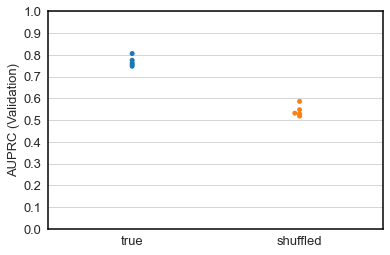

In [102]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=trial_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

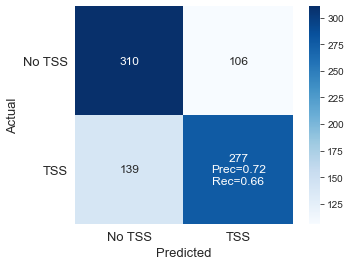

In [131]:
# prepare an average confusion matrix for the 5-fold CV
true_result_df = trial_result_df[trial_result_df['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn, fp],
        [fn, tp]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

annot = conf_mat.copy()
annot = annot.astype(int)
annot = annot.astype(str)
annot.iloc[1, 1] = f'{int(tp)}\nPrec={tp/(tp+fp):.2f}\nRec={tp/(tp+fn):.2f}'
sns.heatmap(conf_mat, cmap='Blues', square=True,
            annot=annot, annot_kws={'fontsize': 12}, fmt='', ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

So we can get some kind of signal; let's try a broader hyperparameter sweep approach and put this all into a pipeline

## Optimizing for Precision

We want to maximize precision - the proportion of predicted positives that are true - because we want to use this model to find high-confidence new TSSes in the genome

This is the same as minimizing false discovery rate (FDR) because FDR = 1 - precision

We can approximate this by weighting the loss function with class_weight

### Class Weights

In [175]:
neg_class_weights = np.logspace(-1, 1, num=12)

cw_result_dfs = {}
for neg_class_weight in neg_class_weights:

    cw_result_df = run_trial(
        regulondb_tss,
        n_upstream=50, n_downstream=20, n_negative_per=1,
        n_filters=8, filter_size=6, stride=1,
        pool_size=12, pool_stride=12,
        n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
        batch_size=16, epochs=50, patience=5, class_weight={0: neg_class_weight, 1: 1.}
    )
    cw_result_dfs[neg_class_weight] = cw_result_df

Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.1749 - accuracy: 0.5000 - auroc: 0.5095 - auprc: 0.5012 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 1.1847 - val_accuracy: 0.5000 - val_auroc: 0.5278 - val_auprc: 0.5169 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.5000 - auroc: 0.5598 - auprc: 0.5534 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 1.1876 - val_accuracy: 0.5000 - val_auroc: 0.5776 - val_auprc: 0.5597 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.5000 - auroc: 0.6409 - auprc: 0.6331 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 1.1979 - val_accuracy: 0.5000 - val_auroc: 0.7000 - val_auprc: 0.6839 

Text(0, 0.5, 'Count')

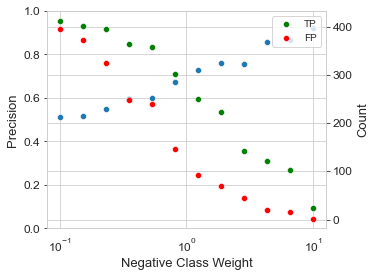

In [176]:
tps = []
fps = []
precisions = []
for cw, cw_result_df in cw_result_dfs.items():
    
    true_cw_result_df = cw_result_df[cw_result_df['y_train'] == 'true']
    tp, fp = true_cw_result_df['val_tp'].mean(), true_cw_result_df['val_fp'].mean()
    precision = tp / (tp + fp)
    tps.append(tp)
    fps.append(fp)
    precisions.append(precision)
    
# make a plot showing the TPs and FPs on one axis and precision on another
sns.set_style('whitegrid')
_, ax_prec = plt.subplots(figsize=(5, 4))
sns.scatterplot(x=cw_result_dfs.keys(), y=precisions, ax=ax_prec)
ax_prec.tick_params(axis='both', labelsize=12)
ax_prec.set_ylim(0, 1)
ax_prec.set_xlabel('Negative Class Weight', fontsize=13)
ax_prec.set_ylabel('Precision', fontsize=13)
ax_prec.set_xscale('log')

ax_tpfp = ax_prec.twinx()
sns.scatterplot(x=cw_result_dfs.keys(), y=tps, ax=ax_tpfp, label='TP', color='green')
sns.scatterplot(x=cw_result_dfs.keys(), y=fps, ax=ax_tpfp, label='FP', color='red')
ax_tpfp.tick_params(axis='both', labelsize=12)
ax_tpfp.set_ylabel('Count', fontsize=13)

### F-beta Loss

In [105]:
betas = np.logspace(-3, 0, num=20)

beta_result_dfs = {}
for beta in betas:

    beta_result_df = run_trial(
        regulondb_tss,
        n_upstream=50, n_downstream=20, n_negative_per=1,
        n_filters=8, filter_size=6, stride=1,
        pool_size=12, pool_stride=12,
        n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
        beta=beta,
        batch_size=16, epochs=50, patience=5
    )
    beta_result_dfs[beta] = beta_result_df

Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.4655 - accuracy: 0.5000 - auroc: 0.5214 - auprc: 0.5188 - fn: 1667.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 0.0000e+00 - val_loss: 0.4130 - val_accuracy: 0.5000 - val_auroc: 0.6552 - val_auprc: 0.6213 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 0.0000e+00
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.5000 - auroc: 0.5531 - auprc: 0.5644 - fn: 1667.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 0.0000e+00 - val_loss: 0.3255 - val_accuracy: 0.5000 - val_auroc: 0.5107 - val_auprc: 0.5201 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 0.0000e+00
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2255 - accuracy: 0.5000 - auroc: 0.5575 - auprc: 0.5902 - fn: 1667.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 0.0000e+00 - val_loss: 0.3079 - val_accuracy: 0.5000 - val_auroc: 0.5492 - val_auprc: 0.5753 

209/209 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.5619 - auroc: 0.6654 - auprc: 0.7048 - fn: 1427.0000 - fp: 34.0000 - tn: 1634.0000 - tp: 240.0000 - val_loss: 0.1385 - val_accuracy: 0.5258 - val_auroc: 0.6120 - val_auprc: 0.6541 - val_fn: 390.0000 - val_fp: 5.0000 - val_tn: 411.0000 - val_tp: 27.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.5583 - auroc: 0.6476 - auprc: 0.6891 - fn: 1448.0000 - fp: 25.0000 - tn: 1643.0000 - tp: 219.0000 - val_loss: 0.1325 - val_accuracy: 0.5522 - val_auroc: 0.6416 - val_auprc: 0.6800 - val_fn: 366.0000 - val_fp: 7.0000 - val_tn: 409.0000 - val_tp: 51.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1269 - accuracy: 0.5595 - auroc: 0.6526 - auprc: 0.7016 - fn: 1452.0000 - fp: 17.0000 - tn: 1651.0000 - tp: 215.0000 - val_loss: 0.1491 - val_accuracy: 0.5426 - val_auroc: 0.6361 - val_auprc: 0.6747 - val_fn: 374.0000 - val_fp: 7.0000 - va

Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.5385 - auroc: 0.5988 - auprc: 0.6544 - fn: 1534.0000 - fp: 5.0000 - tn: 1662.0000 - tp: 134.0000 - val_loss: 0.2822 - val_accuracy: 0.5102 - val_auroc: 0.5418 - val_auprc: 0.5559 - val_fn: 404.0000 - val_fp: 4.0000 - val_tn: 413.0000 - val_tp: 12.0000
Epoch 10/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1620 - accuracy: 0.5202 - auroc: 0.5770 - auprc: 0.6272 - fn: 1596.0000 - fp: 4.0000 - tn: 1663.0000 - tp: 72.0000 - val_loss: 0.2706 - val_accuracy: 0.5066 - val_auroc: 0.5369 - val_auprc: 0.5507 - val_fn: 407.0000 - val_fp: 4.0000 - val_tn: 413.0000 - val_tp: 9.0000
Epoch 11/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.5169 - auroc: 0.5729 - auprc: 0.6260 - fn: 1608.0000 - fp: 3.0000 - tn: 1664.0000 - tp: 60.0000 - val_loss: 0.2457 - val_accuracy: 0.5162 - val_auroc: 0.5597 - val_auprc: 0.5755 - val_fn: 395.0000 - val_fp: 8.00

209/209 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.5198 - auroc: 0.6099 - auprc: 0.6725 - fn: 1601.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 66.0000 - val_loss: 0.2559 - val_accuracy: 0.5096 - val_auroc: 0.5572 - val_auprc: 0.6007 - val_fn: 409.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 8.0000
Epoch 7/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1160 - accuracy: 0.5225 - auroc: 0.6099 - auprc: 0.6756 - fn: 1592.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 75.0000 - val_loss: 0.2563 - val_accuracy: 0.5180 - val_auroc: 0.5796 - val_auprc: 0.6262 - val_fn: 401.0000 - val_fp: 1.0000 - val_tn: 416.0000 - val_tp: 16.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.5219 - auroc: 0.6043 - auprc: 0.6708 - fn: 1594.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 73.0000 - val_loss: 0.2588 - val_accuracy: 0.5264 - val_auroc: 0.5920 - val_auprc: 0.6405 - val_fn: 394.0000 - val_fp: 1.

209/209 [==============================] - 0s 2ms/step - loss: 0.1349 - accuracy: 0.5205 - auroc: 0.5789 - auprc: 0.6333 - fn: 1596.0000 - fp: 3.0000 - tn: 1664.0000 - tp: 72.0000 - val_loss: 0.2355 - val_accuracy: 0.5222 - val_auroc: 0.5697 - val_auprc: 0.6102 - val_fn: 396.0000 - val_fp: 2.0000 - val_tn: 415.0000 - val_tp: 20.0000
Epoch 11/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1457 - accuracy: 0.5244 - auroc: 0.5944 - auprc: 0.6493 - fn: 1580.0000 - fp: 6.0000 - tn: 1661.0000 - tp: 88.0000 - val_loss: 0.2518 - val_accuracy: 0.5318 - val_auroc: 0.5792 - val_auprc: 0.6162 - val_fn: 388.0000 - val_fp: 2.0000 - val_tn: 415.0000 - val_tp: 28.0000
Epoch 12/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1394 - accuracy: 0.5289 - auroc: 0.5913 - auprc: 0.6478 - fn: 1568.0000 - fp: 3.0000 - tn: 1664.0000 - tp: 100.0000 - val_loss: 0.2280 - val_accuracy: 0.5222 - val_auroc: 0.5590 - val_auprc: 0.5991 - val_fn: 396.0000 - val_fp: 2.0000 - val_t

Epoch 14/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1053 - accuracy: 0.5321 - auroc: 0.6217 - auprc: 0.6876 - fn: 1558.0000 - fp: 2.0000 - tn: 1665.0000 - tp: 109.0000 - val_loss: 0.1346 - val_accuracy: 0.5144 - val_auroc: 0.5723 - val_auprc: 0.6125 - val_fn: 403.0000 - val_fp: 2.0000 - val_tn: 415.0000 - val_tp: 14.0000
Epoch 15/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1044 - accuracy: 0.5324 - auroc: 0.6052 - auprc: 0.6703 - fn: 1558.0000 - fp: 1.0000 - tn: 1666.0000 - tp: 109.0000 - val_loss: 0.1456 - val_accuracy: 0.5192 - val_auroc: 0.5714 - val_auprc: 0.6107 - val_fn: 399.0000 - val_fp: 2.0000 - val_tn: 415.0000 - val_tp: 18.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.5006 - accuracy: 0.5000 - auroc: 0.4918 - auprc: 0.4884 - fn: 4.0000 - fp: 1663.0000 - tn: 4.0000 - tp: 1663.0000 - val_loss: 0.5025 - val_accuracy: 0.5000 - val_auroc: 0.4410 - val_auprc: 0.4511 - val_fn: 0.0000e+00 - val_fp: 4

209/209 [==============================] - 0s 2ms/step - loss: 0.2670 - accuracy: 0.6894 - auroc: 0.7399 - auprc: 0.7591 - fn: 900.0000 - fp: 136.0000 - tn: 1532.0000 - tp: 767.0000 - val_loss: 0.3319 - val_accuracy: 0.5918 - val_auroc: 0.6315 - val_auprc: 0.6721 - val_fn: 313.0000 - val_fp: 27.0000 - val_tn: 389.0000 - val_tp: 104.0000
Epoch 12/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.6837 - auroc: 0.7323 - auprc: 0.7566 - fn: 922.0000 - fp: 133.0000 - tn: 1535.0000 - tp: 745.0000 - val_loss: 0.3125 - val_accuracy: 0.6218 - val_auroc: 0.6838 - val_auprc: 0.6926 - val_fn: 260.0000 - val_fp: 55.0000 - val_tn: 361.0000 - val_tp: 157.0000
Epoch 13/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2461 - accuracy: 0.6795 - auroc: 0.7303 - auprc: 0.7513 - fn: 928.0000 - fp: 141.0000 - tn: 1527.0000 - tp: 739.0000 - val_loss: 0.3105 - val_accuracy: 0.6074 - val_auroc: 0.6617 - val_auprc: 0.6778 - val_fn: 278.0000 - val_fp: 49.00

209/209 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.5546 - auroc: 0.6552 - auprc: 0.6936 - fn: 1461.0000 - fp: 24.0000 - tn: 1643.0000 - tp: 206.0000 - val_loss: 0.1919 - val_accuracy: 0.5695 - val_auroc: 0.6533 - val_auprc: 0.6937 - val_fn: 350.0000 - val_fp: 9.0000 - val_tn: 408.0000 - val_tp: 67.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.5396 - auroc: 0.6256 - auprc: 0.6726 - fn: 1523.0000 - fp: 12.0000 - tn: 1655.0000 - tp: 144.0000 - val_loss: 0.1802 - val_accuracy: 0.5540 - val_auroc: 0.6200 - val_auprc: 0.6701 - val_fn: 369.0000 - val_fp: 3.0000 - val_tn: 414.0000 - val_tp: 48.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1483 - accuracy: 0.5660 - auroc: 0.6528 - auprc: 0.6942 - fn: 1412.0000 - fp: 35.0000 - tn: 1632.0000 - tp: 255.0000 - val_loss: 0.1871 - val_accuracy: 0.5671 - val_auroc: 0.6349 - val_auprc: 0.6819 - val_fn: 356.0000 - val_fp: 5.0000 - va

209/209 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.5513 - auroc: 0.6300 - auprc: 0.6967 - fn: 1493.0000 - fp: 3.0000 - tn: 1664.0000 - tp: 174.0000 - val_loss: 0.2149 - val_accuracy: 0.5312 - val_auroc: 0.5837 - val_auprc: 0.6229 - val_fn: 387.0000 - val_fp: 4.0000 - val_tn: 413.0000 - val_tp: 30.0000
Epoch 18/50
209/209 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.5519 - auroc: 0.6253 - auprc: 0.6917 - fn: 1490.0000 - fp: 4.0000 - tn: 1663.0000 - tp: 177.0000 - val_loss: 0.2185 - val_accuracy: 0.5408 - val_auroc: 0.6014 - val_auprc: 0.6425 - val_fn: 374.0000 - val_fp: 9.0000 - val_tn: 408.0000 - val_tp: 43.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4999 - accuracy: 0.5003 - auroc: 0.5054 - auprc: 0.5037 - fn: 21.0000 - fp: 1645.0000 - tn: 22.0000 - tp: 1646.0000 - val_loss: 0.4987 - val_accuracy: 0.5108 - val_auroc: 0.5130 - val_auprc: 0.5146 - val_fn: 38.0000 - val_fp: 370.0000 - val

Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4995 - accuracy: 0.4987 - auroc: 0.5115 - auprc: 0.5168 - fn: 17.0000 - fp: 1655.0000 - tn: 13.0000 - tp: 1650.0000 - val_loss: 0.4987 - val_accuracy: 0.5018 - val_auroc: 0.5079 - val_auprc: 0.5345 - val_fn: 1.0000 - val_fp: 414.0000 - val_tn: 2.0000 - val_tp: 416.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4983 - accuracy: 0.5028 - auroc: 0.5239 - auprc: 0.5165 - fn: 95.0000 - fp: 1563.0000 - tn: 105.0000 - tp: 1572.0000 - val_loss: 0.4984 - val_accuracy: 0.5102 - val_auroc: 0.5098 - val_auprc: 0.5266 - val_fn: 41.0000 - val_fp: 367.0000 - val_tn: 49.0000 - val_tp: 376.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.5394 - auroc: 0.5507 - auprc: 0.5384 - fn: 601.0000 - fp: 935.0000 - tn: 733.0000 - tp: 1066.0000 - val_loss: 0.4984 - val_accuracy: 0.5066 - val_auroc: 0.5058 - val_auprc: 0.5221 - val_fn: 19.0000 - val_fp: 39

Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.5120 - auroc: 0.5508 - auprc: 0.5678 - fn: 1608.0000 - fp: 19.0000 - tn: 1648.0000 - tp: 59.0000 - val_loss: 0.4429 - val_accuracy: 0.4988 - val_auroc: 0.5210 - val_auprc: 0.5184 - val_fn: 411.0000 - val_fp: 7.0000 - val_tn: 410.0000 - val_tp: 6.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3136 - accuracy: 0.5168 - auroc: 0.5555 - auprc: 0.5765 - fn: 1584.0000 - fp: 27.0000 - tn: 1640.0000 - tp: 83.0000 - val_loss: 0.4209 - val_accuracy: 0.5036 - val_auroc: 0.5246 - val_auprc: 0.5257 - val_fn: 392.0000 - val_fp: 22.0000 - val_tn: 395.0000 - val_tp: 25.0000
Epoch 10/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.5153 - auroc: 0.5496 - auprc: 0.5800 - fn: 1604.0000 - fp: 12.0000 - tn: 1655.0000 - tp: 63.0000 - val_loss: 0.4302 - val_accuracy: 0.5060 - val_auroc: 0.5275 - val_auprc: 0.5273 - val_fn: 396.0000 - val_fp: 16

209/209 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.5418 - auroc: 0.6274 - auprc: 0.6929 - fn: 1525.0000 - fp: 3.0000 - tn: 1665.0000 - tp: 142.0000 - val_loss: 0.2051 - val_accuracy: 0.5186 - val_auroc: 0.5565 - val_auprc: 0.5912 - val_fn: 399.0000 - val_fp: 2.0000 - val_tn: 414.0000 - val_tp: 18.0000
Epoch 11/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1115 - accuracy: 0.5424 - auroc: 0.6223 - auprc: 0.6846 - fn: 1523.0000 - fp: 3.0000 - tn: 1665.0000 - tp: 144.0000 - val_loss: 0.1958 - val_accuracy: 0.5270 - val_auroc: 0.6034 - val_auprc: 0.6335 - val_fn: 384.0000 - val_fp: 10.0000 - val_tn: 406.0000 - val_tp: 33.0000
Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.4989 - accuracy: 0.5031 - auroc: 0.5120 - auprc: 0.5165 - fn: 1623.0000 - fp: 34.0000 - tn: 1634.0000 - tp: 44.0000 - val_loss: 0.4996 - val_accuracy: 0.5102 - val_auroc: 0.4847 - val_auprc: 0.5019 - val_fn: 382.0000 - val_fp: 26.0000 - va

209/209 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.4997 - auroc: 0.5321 - auprc: 0.5317 - fn: 1666.0000 - fp: 2.0000 - tn: 1665.0000 - tp: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.5000 - val_auroc: 0.5068 - val_auprc: 0.5025 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 0.0000e+00
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.5015 - auroc: 0.5458 - auprc: 0.5552 - fn: 1659.0000 - fp: 3.0000 - tn: 1664.0000 - tp: 8.0000 - val_loss: 0.5183 - val_accuracy: 0.4964 - val_auroc: 0.4947 - val_auprc: 0.4941 - val_fn: 413.0000 - val_fp: 7.0000 - val_tn: 410.0000 - val_tp: 4.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3590 - accuracy: 0.5069 - auroc: 0.5522 - auprc: 0.5701 - fn: 1636.0000 - fp: 8.0000 - tn: 1659.0000 - tp: 31.0000 - val_loss: 0.5014 - val_accuracy: 0.5000 - val_auroc: 0.5019 - val_auprc: 0.4998 - val_fn: 412.0000 - val_fp: 5.0000 - val_

Epoch 7/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1619 - accuracy: 0.5234 - auroc: 0.6098 - auprc: 0.6619 - fn: 1584.0000 - fp: 5.0000 - tn: 1662.0000 - tp: 83.0000 - val_loss: 0.3223 - val_accuracy: 0.5204 - val_auroc: 0.5594 - val_auprc: 0.5880 - val_fn: 399.0000 - val_fp: 1.0000 - val_tn: 416.0000 - val_tp: 18.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.5246 - auroc: 0.6109 - auprc: 0.6649 - fn: 1579.0000 - fp: 6.0000 - tn: 1661.0000 - tp: 88.0000 - val_loss: 0.3111 - val_accuracy: 0.5288 - val_auroc: 0.6019 - val_auprc: 0.6172 - val_fn: 378.0000 - val_fp: 15.0000 - val_tn: 402.0000 - val_tp: 39.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.5007 - accuracy: 0.4952 - auroc: 0.4934 - auprc: 0.4910 - fn: 1363.0000 - fp: 320.0000 - tn: 1347.0000 - tp: 304.0000 - val_loss: 0.4993 - val_accuracy: 0.4988 - val_auroc: 0.5145 - val_auprc: 0.5278 - val_fn: 30.0000 - val_fp: 388

209/209 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.5070 - auroc: 0.5578 - auprc: 0.5545 - fn: 1619.0000 - fp: 25.0000 - tn: 1643.0000 - tp: 48.0000 - val_loss: 0.5301 - val_accuracy: 0.4994 - val_auroc: 0.5078 - val_auprc: 0.4967 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 416.0000 - val_tp: 0.0000e+00
Epoch 7/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.5058 - auroc: 0.5626 - auprc: 0.5704 - fn: 1633.0000 - fp: 15.0000 - tn: 1653.0000 - tp: 34.0000 - val_loss: 0.5493 - val_accuracy: 0.4994 - val_auroc: 0.4850 - val_auprc: 0.4812 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 416.0000 - val_tp: 0.0000e+00
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4793 - accuracy: 0.5001 - auroc: 0.5573 - auprc: 0.5346 - fn: 1662.0000 - fp: 5.0000 - tn: 1662.0000 - tp: 6.0000 - val_loss: 0.4414 - val_accuracy: 0.5006 - val_auroc: 0.6243 - val_auprc: 0.6057 - val_fn: 416.0000 - val_fp: 0.

Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4984 - accuracy: 0.5027 - auroc: 0.5237 - auprc: 0.5269 - fn: 50.0000 - fp: 1608.0000 - tn: 59.0000 - tp: 1617.0000 - val_loss: 0.4987 - val_accuracy: 0.4952 - val_auroc: 0.5201 - val_auprc: 0.5216 - val_fn: 21.0000 - val_fp: 400.0000 - val_tn: 17.0000 - val_tp: 396.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.5180 - auroc: 0.5173 - auprc: 0.5261 - fn: 1238.0000 - fp: 369.0000 - tn: 1298.0000 - tp: 429.0000 - val_loss: 0.4987 - val_accuracy: 0.5000 - val_auroc: 0.5157 - val_auprc: 0.5128 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 0.0000e+00
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4870 - accuracy: 0.5000 - auroc: 0.5212 - auprc: 0.5185 - fn: 1667.0000 - fp: 0.0000e+00 - tn: 1667.0000 - tp: 0.0000e+00 - val_loss: 0.4984 - val_accuracy: 0.5000 - val_auroc: 0.5005 - val_auprc: 0.5026 - val_fn: 417.00

Epoch 12/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.5448 - auroc: 0.6460 - auprc: 0.7048 - fn: 1512.0000 - fp: 6.0000 - tn: 1662.0000 - tp: 155.0000 - val_loss: 0.1921 - val_accuracy: 0.5702 - val_auroc: 0.6642 - val_auprc: 0.6991 - val_fn: 349.0000 - val_fp: 9.0000 - val_tn: 407.0000 - val_tp: 68.0000
Epoch 13/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1114 - accuracy: 0.5556 - auroc: 0.6588 - auprc: 0.7113 - fn: 1464.0000 - fp: 18.0000 - tn: 1650.0000 - tp: 203.0000 - val_loss: 0.2145 - val_accuracy: 0.6110 - val_auroc: 0.6768 - val_auprc: 0.7063 - val_fn: 302.0000 - val_fp: 22.0000 - val_tn: 394.0000 - val_tp: 115.0000
Epoch 14/50
209/209 [==============================] - 0s 2ms/step - loss: 0.0975 - accuracy: 0.5445 - auroc: 0.6473 - auprc: 0.7041 - fn: 1509.0000 - fp: 10.0000 - tn: 1658.0000 - tp: 158.0000 - val_loss: 0.1720 - val_accuracy: 0.5498 - val_auroc: 0.6503 - val_auprc: 0.6909 - val_fn: 365.0000 - val_

209/209 [==============================] - 1s 2ms/step - loss: 0.3061 - accuracy: 0.5249 - auroc: 0.5646 - auprc: 0.5915 - fn: 1551.0000 - fp: 33.0000 - tn: 1634.0000 - tp: 116.0000 - val_loss: 0.5614 - val_accuracy: 0.5036 - val_auroc: 0.4729 - val_auprc: 0.4838 - val_fn: 410.0000 - val_fp: 4.0000 - val_tn: 413.0000 - val_tp: 7.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3033 - accuracy: 0.5219 - auroc: 0.5707 - auprc: 0.6054 - fn: 1578.0000 - fp: 16.0000 - tn: 1651.0000 - tp: 89.0000 - val_loss: 0.5521 - val_accuracy: 0.4952 - val_auroc: 0.4600 - val_auprc: 0.4760 - val_fn: 402.0000 - val_fp: 19.0000 - val_tn: 398.0000 - val_tp: 15.0000
Epoch 10/50
209/209 [==============================] - 1s 3ms/step - loss: 0.2903 - accuracy: 0.5246 - auroc: 0.5777 - auprc: 0.6146 - fn: 1571.0000 - fp: 14.0000 - tn: 1653.0000 - tp: 96.0000 - val_loss: 0.5695 - val_accuracy: 0.4904 - val_auroc: 0.4556 - val_auprc: 0.4730 - val_fn: 402.0000 - val_fp: 23.0000 - va

209/209 [==============================] - 1s 3ms/step - loss: 0.4971 - accuracy: 0.4997 - auroc: 0.5379 - auprc: 0.5300 - fn: 1648.0000 - fp: 20.0000 - tn: 1647.0000 - tp: 19.0000 - val_loss: 0.4938 - val_accuracy: 0.5036 - val_auroc: 0.5366 - val_auprc: 0.5326 - val_fn: 407.0000 - val_fp: 7.0000 - val_tn: 410.0000 - val_tp: 10.0000
Epoch 4/50
209/209 [==============================] - 1s 3ms/step - loss: 0.4804 - accuracy: 0.5006 - auroc: 0.5306 - auprc: 0.5289 - fn: 1661.0000 - fp: 4.0000 - tn: 1663.0000 - tp: 6.0000 - val_loss: 0.4648 - val_accuracy: 0.5000 - val_auroc: 0.5349 - val_auprc: 0.5351 - val_fn: 417.0000 - val_fp: 0.0000e+00 - val_tn: 417.0000 - val_tp: 0.0000e+00
Epoch 5/50
209/209 [==============================] - 1s 3ms/step - loss: 0.4483 - accuracy: 0.5036 - auroc: 0.5271 - auprc: 0.5230 - fn: 1584.0000 - fp: 71.0000 - tn: 1596.0000 - tp: 83.0000 - val_loss: 0.4487 - val_accuracy: 0.5000 - val_auroc: 0.5268 - val_auprc: 0.5316 - val_fn: 413.0000 - val_fp: 4.0000 - 

Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.5445 - auroc: 0.6449 - auprc: 0.6825 - fn: 1493.0000 - fp: 26.0000 - tn: 1641.0000 - tp: 175.0000 - val_loss: 0.2381 - val_accuracy: 0.5834 - val_auroc: 0.6652 - val_auprc: 0.6847 - val_fn: 326.0000 - val_fp: 21.0000 - val_tn: 396.0000 - val_tp: 90.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1655 - accuracy: 0.5493 - auroc: 0.6488 - auprc: 0.6898 - fn: 1483.0000 - fp: 20.0000 - tn: 1647.0000 - tp: 185.0000 - val_loss: 0.1994 - val_accuracy: 0.5354 - val_auroc: 0.6152 - val_auprc: 0.6536 - val_fn: 382.0000 - val_fp: 5.0000 - val_tn: 412.0000 - val_tp: 34.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1579 - accuracy: 0.5571 - auroc: 0.6521 - auprc: 0.6973 - fn: 1460.0000 - fp: 17.0000 - tn: 1650.0000 - tp: 208.0000 - val_loss: 0.2115 - val_accuracy: 0.5558 - val_auroc: 0.6384 - val_auprc: 0.6690 - val_fn: 359.0000 - val_fp:

209/209 [==============================] - 1s 5ms/step - loss: 0.5001 - accuracy: 0.5045 - auroc: 0.5072 - auprc: 0.5050 - fn: 426.0000 - fp: 1226.0000 - tn: 441.0000 - tp: 1241.0000 - val_loss: 0.4988 - val_accuracy: 0.5024 - val_auroc: 0.5406 - val_auprc: 0.5301 - val_fn: 1.0000 - val_fp: 414.0000 - val_tn: 3.0000 - val_tp: 416.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4984 - accuracy: 0.5078 - auroc: 0.5226 - auprc: 0.5244 - fn: 551.0000 - fp: 1090.0000 - tn: 577.0000 - tp: 1116.0000 - val_loss: 0.4985 - val_accuracy: 0.4988 - val_auroc: 0.5405 - val_auprc: 0.5230 - val_fn: 393.0000 - val_fp: 25.0000 - val_tn: 392.0000 - val_tp: 24.0000
Epoch 3/50
209/209 [==============================] - 1s 3ms/step - loss: 0.4946 - accuracy: 0.5342 - auroc: 0.5486 - auprc: 0.5442 - fn: 1081.0000 - fp: 472.0000 - tn: 1195.0000 - tp: 586.0000 - val_loss: 0.4909 - val_accuracy: 0.5420 - val_auroc: 0.5552 - val_auprc: 0.5296 - val_fn: 237.0000 - val_fp: 145.0000

209/209 [==============================] - 0s 2ms/step - loss: 0.1037 - accuracy: 0.5742 - auroc: 0.6650 - auprc: 0.7249 - fn: 1407.0000 - fp: 13.0000 - tn: 1655.0000 - tp: 260.0000 - val_loss: 0.1528 - val_accuracy: 0.5486 - val_auroc: 0.6187 - val_auprc: 0.6734 - val_fn: 375.0000 - val_fp: 1.0000 - val_tn: 415.0000 - val_tp: 42.0000
Epoch 12/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1061 - accuracy: 0.5796 - auroc: 0.6777 - auprc: 0.7357 - fn: 1388.0000 - fp: 14.0000 - tn: 1654.0000 - tp: 279.0000 - val_loss: 0.1770 - val_accuracy: 0.5570 - val_auroc: 0.6273 - val_auprc: 0.6763 - val_fn: 362.0000 - val_fp: 7.0000 - val_tn: 409.0000 - val_tp: 55.0000
Epoch 13/50
209/209 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.5799 - auroc: 0.6706 - auprc: 0.7313 - fn: 1390.0000 - fp: 11.0000 - tn: 1657.0000 - tp: 277.0000 - val_loss: 0.1740 - val_accuracy: 0.5402 - val_auroc: 0.6082 - val_auprc: 0.6616 - val_fn: 381.0000 - val_fp: 2.0000 - 

209/209 [==============================] - 0s 2ms/step - loss: 0.3199 - accuracy: 0.5069 - auroc: 0.5784 - auprc: 0.5976 - fn: 1630.0000 - fp: 14.0000 - tn: 1653.0000 - tp: 37.0000 - val_loss: 0.4868 - val_accuracy: 0.4952 - val_auroc: 0.5151 - val_auprc: 0.5087 - val_fn: 410.0000 - val_fp: 11.0000 - val_tn: 406.0000 - val_tp: 7.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2922 - accuracy: 0.5195 - auroc: 0.5670 - auprc: 0.5874 - fn: 1580.0000 - fp: 22.0000 - tn: 1645.0000 - tp: 87.0000 - val_loss: 0.4731 - val_accuracy: 0.5048 - val_auroc: 0.5076 - val_auprc: 0.5122 - val_fn: 385.0000 - val_fp: 28.0000 - val_tn: 389.0000 - val_tp: 32.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2959 - accuracy: 0.5291 - auroc: 0.5703 - auprc: 0.6042 - fn: 1546.0000 - fp: 24.0000 - tn: 1643.0000 - tp: 121.0000 - val_loss: 0.4799 - val_accuracy: 0.5000 - val_auroc: 0.5108 - val_auprc: 0.5086 - val_fn: 404.0000 - val_fp: 13.0000 - va

209/209 [==============================] - 0s 2ms/step - loss: 0.2044 - accuracy: 0.5436 - auroc: 0.6505 - auprc: 0.6788 - fn: 1496.0000 - fp: 26.0000 - tn: 1642.0000 - tp: 171.0000 - val_loss: 0.2586 - val_accuracy: 0.5234 - val_auroc: 0.6109 - val_auprc: 0.6245 - val_fn: 387.0000 - val_fp: 10.0000 - val_tn: 406.0000 - val_tp: 30.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.5496 - auroc: 0.6531 - auprc: 0.6872 - fn: 1468.0000 - fp: 34.0000 - tn: 1634.0000 - tp: 199.0000 - val_loss: 0.2582 - val_accuracy: 0.5402 - val_auroc: 0.6308 - val_auprc: 0.6404 - val_fn: 366.0000 - val_fp: 17.0000 - val_tn: 399.0000 - val_tp: 51.0000
Epoch 7/50
209/209 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.5592 - auroc: 0.6469 - auprc: 0.6878 - fn: 1442.0000 - fp: 28.0000 - tn: 1640.0000 - tp: 225.0000 - val_loss: 0.2418 - val_accuracy: 0.5354 - val_auroc: 0.6139 - val_auprc: 0.6339 - val_fn: 373.0000 - val_fp: 14.0000 -

209/209 [==============================] - 0s 2ms/step - loss: 0.4941 - accuracy: 0.5051 - auroc: 0.5104 - auprc: 0.5162 - fn: 1302.0000 - fp: 348.0000 - tn: 1319.0000 - tp: 365.0000 - val_loss: 0.5006 - val_accuracy: 0.4928 - val_auroc: 0.4973 - val_auprc: 0.4884 - val_fn: 376.0000 - val_fp: 47.0000 - val_tn: 370.0000 - val_tp: 41.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4834 - accuracy: 0.5021 - auroc: 0.5217 - auprc: 0.5145 - fn: 1616.0000 - fp: 44.0000 - tn: 1623.0000 - tp: 51.0000 - val_loss: 0.5067 - val_accuracy: 0.4988 - val_auroc: 0.4895 - val_auprc: 0.4888 - val_fn: 417.0000 - val_fp: 1.0000 - val_tn: 416.0000 - val_tp: 0.0000e+00
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.5063 - auroc: 0.5469 - auprc: 0.5385 - fn: 1542.0000 - fp: 104.0000 - tn: 1563.0000 - tp: 125.0000 - val_loss: 0.4910 - val_accuracy: 0.5024 - val_auroc: 0.5160 - val_auprc: 0.5121 - val_fn: 406.0000 - val_fp: 9.0000

209/209 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.5336 - auroc: 0.5594 - auprc: 0.5487 - fn: 268.0000 - fp: 1287.0000 - tn: 380.0000 - tp: 1399.0000 - val_loss: 0.5038 - val_accuracy: 0.4844 - val_auroc: 0.4835 - val_auprc: 0.4772 - val_fn: 102.0000 - val_fp: 328.0000 - val_tn: 89.0000 - val_tp: 315.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.5315 - auroc: 0.5448 - auprc: 0.5471 - fn: 1171.0000 - fp: 391.0000 - tn: 1276.0000 - tp: 496.0000 - val_loss: 0.5109 - val_accuracy: 0.4868 - val_auroc: 0.4807 - val_auprc: 0.4760 - val_fn: 258.0000 - val_fp: 170.0000 - val_tn: 247.0000 - val_tp: 159.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.5156 - auroc: 0.5491 - auprc: 0.5478 - fn: 1506.0000 - fp: 109.0000 - tn: 1558.0000 - tp: 161.0000 - val_loss: 0.5558 - val_accuracy: 0.4892 - val_auroc: 0.4730 - val_auprc: 0.4692 - val_fn: 414.0000 - val_fp: 12.

209/209 [==============================] - 0s 2ms/step - loss: 0.3048 - accuracy: 0.5397 - auroc: 0.5801 - auprc: 0.5978 - fn: 1476.0000 - fp: 59.0000 - tn: 1608.0000 - tp: 192.0000 - val_loss: 0.5234 - val_accuracy: 0.5042 - val_auroc: 0.5045 - val_auprc: 0.5108 - val_fn: 357.0000 - val_fp: 56.0000 - val_tn: 361.0000 - val_tp: 59.0000
Epoch 13/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2916 - accuracy: 0.5403 - auroc: 0.5887 - auprc: 0.6167 - fn: 1501.0000 - fp: 32.0000 - tn: 1635.0000 - tp: 167.0000 - val_loss: 0.5340 - val_accuracy: 0.5102 - val_auroc: 0.4994 - val_auprc: 0.5104 - val_fn: 396.0000 - val_fp: 12.0000 - val_tn: 405.0000 - val_tp: 20.0000
Epoch 14/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3178 - accuracy: 0.5451 - auroc: 0.5757 - auprc: 0.6106 - fn: 1473.0000 - fp: 44.0000 - tn: 1623.0000 - tp: 195.0000 - val_loss: 0.4964 - val_accuracy: 0.5066 - val_auroc: 0.5018 - val_auprc: 0.5123 - val_fn: 388.0000 - val_fp: 23.0000

209/209 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.5180 - auroc: 0.5217 - auprc: 0.5275 - fn: 1446.0000 - fp: 161.0000 - tn: 1506.0000 - tp: 221.0000 - val_loss: 0.5260 - val_accuracy: 0.4820 - val_auroc: 0.4545 - val_auprc: 0.4594 - val_fn: 384.0000 - val_fp: 48.0000 - val_tn: 369.0000 - val_tp: 33.0000
Epoch 5/50
209/209 [==============================] - 1s 3ms/step - loss: 0.4456 - accuracy: 0.5180 - auroc: 0.5581 - auprc: 0.5536 - fn: 1506.0000 - fp: 101.0000 - tn: 1566.0000 - tp: 161.0000 - val_loss: 0.5516 - val_accuracy: 0.4976 - val_auroc: 0.4532 - val_auprc: 0.4607 - val_fn: 414.0000 - val_fp: 5.0000 - val_tn: 412.0000 - val_tp: 3.0000
Epoch 6/50
209/209 [==============================] - 1s 2ms/step - loss: 0.4276 - accuracy: 0.5168 - auroc: 0.5613 - auprc: 0.5518 - fn: 1432.0000 - fp: 179.0000 - tn: 1488.0000 - tp: 235.0000 - val_loss: 0.5473 - val_accuracy: 0.4628 - val_auroc: 0.4441 - val_auprc: 0.4530 - val_fn: 335.0000 - val_fp: 113.0000

209/209 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.6939 - auroc: 0.7341 - auprc: 0.7291 - fn: 539.0000 - fp: 482.0000 - tn: 1185.0000 - tp: 1129.0000 - val_loss: 0.4050 - val_accuracy: 0.6807 - val_auroc: 0.7378 - val_auprc: 0.7600 - val_fn: 140.0000 - val_fp: 126.0000 - val_tn: 291.0000 - val_tp: 276.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.7115 - auroc: 0.7406 - auprc: 0.7424 - fn: 592.0000 - fp: 370.0000 - tn: 1297.0000 - tp: 1076.0000 - val_loss: 0.3894 - val_accuracy: 0.6867 - val_auroc: 0.7344 - val_auprc: 0.7454 - val_fn: 136.0000 - val_fp: 125.0000 - val_tn: 292.0000 - val_tp: 280.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.7073 - auroc: 0.7384 - auprc: 0.7468 - fn: 673.0000 - fp: 303.0000 - tn: 1364.0000 - tp: 995.0000 - val_loss: 0.3648 - val_accuracy: 0.6759 - val_auroc: 0.7188 - val_auprc: 0.7448 - val_fn: 190.0000 - val_fp: 80.

209/209 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.5270 - auroc: 0.5423 - auprc: 0.5453 - fn: 1254.0000 - fp: 323.0000 - tn: 1344.0000 - tp: 413.0000 - val_loss: 0.5104 - val_accuracy: 0.4736 - val_auroc: 0.4497 - val_auprc: 0.4629 - val_fn: 390.0000 - val_fp: 49.0000 - val_tn: 368.0000 - val_tp: 27.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.5108 - auroc: 0.5515 - auprc: 0.5501 - fn: 1572.0000 - fp: 59.0000 - tn: 1608.0000 - tp: 95.0000 - val_loss: 0.5473 - val_accuracy: 0.4964 - val_auroc: 0.4468 - val_auprc: 0.4619 - val_fn: 411.0000 - val_fp: 9.0000 - val_tn: 408.0000 - val_tp: 6.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.5222 - auroc: 0.5528 - auprc: 0.5461 - fn: 1270.0000 - fp: 323.0000 - tn: 1344.0000 - tp: 397.0000 - val_loss: 0.5530 - val_accuracy: 0.4856 - val_auroc: 0.4533 - val_auprc: 0.4613 - val_fn: 393.0000 - val_fp: 36.0000 - 

209/209 [==============================] - 0s 2ms/step - loss: 0.2561 - accuracy: 0.5718 - auroc: 0.6803 - auprc: 0.6904 - fn: 1343.0000 - fp: 85.0000 - tn: 1582.0000 - tp: 325.0000 - val_loss: 0.2564 - val_accuracy: 0.6579 - val_auroc: 0.7199 - val_auprc: 0.7171 - val_fn: 237.0000 - val_fp: 48.0000 - val_tn: 369.0000 - val_tp: 179.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2385 - accuracy: 0.5835 - auroc: 0.6761 - auprc: 0.6902 - fn: 1293.0000 - fp: 96.0000 - tn: 1571.0000 - tp: 375.0000 - val_loss: 0.2028 - val_accuracy: 0.5678 - val_auroc: 0.6752 - val_auprc: 0.7000 - val_fn: 347.0000 - val_fp: 13.0000 - val_tn: 404.0000 - val_tp: 69.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.6036 - auroc: 0.6884 - auprc: 0.7138 - fn: 1238.0000 - fp: 84.0000 - tn: 1583.0000 - tp: 430.0000 - val_loss: 0.1898 - val_accuracy: 0.5870 - val_auroc: 0.6875 - val_auprc: 0.7138 - val_fn: 326.0000 - val_fp: 18.0000 

209/209 [==============================] - 0s 2ms/step - loss: 0.4969 - accuracy: 0.5000 - auroc: 0.5220 - auprc: 0.5255 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4963 - val_accuracy: 0.5000 - val_auroc: 0.5681 - val_auprc: 0.5516 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4963 - accuracy: 0.5000 - auroc: 0.5201 - auprc: 0.5199 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4944 - val_accuracy: 0.5000 - val_auroc: 0.5702 - val_auprc: 0.5512 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4926 - accuracy: 0.5105 - auroc: 0.5251 - auprc: 0.5256 - fn: 359.0000 - fp: 1273.0000 - tn: 394.0000 - tp: 1308.0000 - val_loss: 0.4861 - val_accuracy: 0.5240 - val_auroc: 0.5774 - val_auprc: 0.5659 - val_fn: 30.00

209/209 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.4999 - auroc: 0.5117 - auprc: 0.5108 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4948 - val_accuracy: 0.5006 - val_auroc: 0.5421 - val_auprc: 0.5229 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.5031 - auroc: 0.5238 - auprc: 0.5183 - fn: 63.0000 - fp: 1594.0000 - tn: 74.0000 - tp: 1604.0000 - val_loss: 0.4977 - val_accuracy: 0.4922 - val_auroc: 0.5477 - val_auprc: 0.5183 - val_fn: 374.0000 - val_fp: 49.0000 - val_tn: 367.0000 - val_tp: 43.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.5352 - auroc: 0.5356 - auprc: 0.5332 - fn: 959.0000 - fp: 591.0000 - tn: 1077.0000 - tp: 708.0000 - val_loss: 0.4834 - val_accuracy: 0.5210 - val_auroc: 0.5574 - val_auprc: 0.5257 - val_fn: 42.0000 - val_fp: 

209/209 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.4949 - auroc: 0.5015 - auprc: 0.5043 - fn: 130.0000 - fp: 1554.0000 - tn: 113.0000 - tp: 1537.0000 - val_loss: 0.4938 - val_accuracy: 0.5000 - val_auroc: 0.5109 - val_auprc: 0.5064 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 8/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.5054 - auroc: 0.5180 - auprc: 0.5155 - fn: 109.0000 - fp: 1540.0000 - tn: 127.0000 - tp: 1558.0000 - val_loss: 0.4865 - val_accuracy: 0.5168 - val_auroc: 0.5494 - val_auprc: 0.5273 - val_fn: 66.0000 - val_fp: 337.0000 - val_tn: 80.0000 - val_tp: 351.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.5288 - auroc: 0.5500 - auprc: 0.5410 - fn: 409.0000 - fp: 1162.0000 - tn: 505.0000 - tp: 1258.0000 - val_loss: 0.4756 - val_accuracy: 0.5300 - val_auroc: 0.5520 - val_auprc: 0.5350 - val_fn: 264.0000 - val_fp: 

209/209 [==============================] - 0s 2ms/step - loss: 0.2951 - accuracy: 0.6072 - auroc: 0.7174 - auprc: 0.7067 - fn: 1145.0000 - fp: 165.0000 - tn: 1503.0000 - tp: 522.0000 - val_loss: 0.2832 - val_accuracy: 0.6062 - val_auroc: 0.7245 - val_auprc: 0.7177 - val_fn: 289.0000 - val_fp: 39.0000 - val_tn: 377.0000 - val_tp: 128.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2677 - accuracy: 0.6342 - auroc: 0.7249 - auprc: 0.7265 - fn: 1079.0000 - fp: 141.0000 - tn: 1527.0000 - tp: 588.0000 - val_loss: 0.2914 - val_accuracy: 0.5834 - val_auroc: 0.7070 - val_auprc: 0.7170 - val_fn: 333.0000 - val_fp: 14.0000 - val_tn: 402.0000 - val_tp: 84.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2397 - accuracy: 0.6396 - auroc: 0.7266 - auprc: 0.7241 - fn: 1054.0000 - fp: 148.0000 - tn: 1520.0000 - tp: 613.0000 - val_loss: 0.2685 - val_accuracy: 0.6471 - val_auroc: 0.7212 - val_auprc: 0.7208 - val_fn: 245.0000 - val_fp: 49.00

209/209 [==============================] - 0s 2ms/step - loss: 0.2337 - accuracy: 0.6812 - auroc: 0.7468 - auprc: 0.7594 - fn: 894.0000 - fp: 169.0000 - tn: 1498.0000 - tp: 773.0000 - val_loss: 0.2772 - val_accuracy: 0.6571 - val_auroc: 0.7305 - val_auprc: 0.7519 - val_fn: 246.0000 - val_fp: 40.0000 - val_tn: 377.0000 - val_tp: 171.0000
Epoch 9/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2320 - accuracy: 0.6896 - auroc: 0.7530 - auprc: 0.7645 - fn: 869.0000 - fp: 166.0000 - tn: 1501.0000 - tp: 798.0000 - val_loss: 0.2779 - val_accuracy: 0.6667 - val_auroc: 0.7289 - val_auprc: 0.7433 - val_fn: 232.0000 - val_fp: 46.0000 - val_tn: 371.0000 - val_tp: 185.0000
Epoch 10/50
209/209 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 0.6833 - auroc: 0.7448 - auprc: 0.7613 - fn: 899.0000 - fp: 157.0000 - tn: 1510.0000 - tp: 768.0000 - val_loss: 0.2777 - val_accuracy: 0.6655 - val_auroc: 0.7266 - val_auprc: 0.7439 - val_fn: 232.0000 - val_fp: 47.000

209/209 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.4997 - auroc: 0.5056 - auprc: 0.5029 - fn: 1.0000 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1666.0000 - val_loss: 0.4876 - val_accuracy: 0.5000 - val_auroc: 0.4988 - val_auprc: 0.4994 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.5000 - auroc: 0.5018 - auprc: 0.5009 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4876 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.5000 - auroc: 0.5006 - auprc: 0.5003 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4876 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.000

209/209 [==============================] - 0s 2ms/step - loss: 0.4749 - accuracy: 0.5000 - auroc: 0.5003 - auprc: 0.5002 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4747 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.5000 - auroc: 0.5003 - auprc: 0.5001 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4747 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4774 - accuracy: 0.5006 - auroc: 0.4960 - auprc: 0.4978 - fn: 3.0000 - fp: 1662.0000 - tn: 5.0000 - tp: 1664.0000 - val_loss: 0.4748 - val_accuracy: 0.5000 - val_auroc: 0.4895 - val_auprc: 0.4944 - val_fn: 0.0000e+0

Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.5000 - auroc: 0.5458 - auprc: 0.5331 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4750 - val_accuracy: 0.5000 - val_auroc: 0.5740 - val_auprc: 0.5636 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.5000 - auroc: 0.5286 - auprc: 0.5165 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4750 - val_accuracy: 0.5000 - val_auroc: 0.5444 - val_auprc: 0.5239 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.5000 - auroc: 0.5321 - auprc: 0.5174 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4750 - val_accuracy: 0.5000 - val_auroc: 0.5360 - val_auprc: 0.5190 

Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4752 - accuracy: 0.4999 - auroc: 0.5015 - auprc: 0.5006 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4736 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4840 - accuracy: 0.5016 - auroc: 0.5180 - auprc: 0.5168 - fn: 109.0000 - fp: 1553.0000 - tn: 115.0000 - tp: 1558.0000 - val_loss: 0.4738 - val_accuracy: 0.5006 - val_auroc: 0.4682 - val_auprc: 0.4714 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.4999 - auroc: 0.5045 - auprc: 0.5024 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4736 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - va

Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.5000 - auroc: 0.4978 - auprc: 0.4978 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4505 - val_accuracy: 0.5000 - val_auroc: 0.4988 - val_auprc: 0.4994 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.5000 - auroc: 0.4970 - auprc: 0.4985 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4504 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4509 - accuracy: 0.5000 - auroc: 0.5006 - auprc: 0.5003 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4504 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 

Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4508 - accuracy: 0.5000 - auroc: 0.4997 - auprc: 0.4998 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4507 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.5000 - auroc: 0.5003 - auprc: 0.5002 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4507 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4559 - accuracy: 0.5003 - auroc: 0.4880 - auprc: 0.4939 - fn: 3.0000 - fp: 1663.0000 - tn: 4.0000 - tp: 1664.0000 - val_loss: 0.4512 - val_accuracy: 0.5000 - val_auroc: 0.4976 - val_auprc: 0.4988 - val_fn

Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.4999 - auroc: 0.4988 - auprc: 0.4992 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4488 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.4999 - auroc: 0.5021 - auprc: 0.5009 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4488 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.4999 - auroc: 0.4982 - auprc: 0.4989 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4488 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 

Epoch 6/50
209/209 [==============================] - 1s 2ms/step - loss: 0.4083 - accuracy: 0.5000 - auroc: 0.5012 - auprc: 0.5006 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4075 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.4175 - accuracy: 0.5009 - auroc: 0.4938 - auprc: 0.4957 - fn: 16.0000 - fp: 1648.0000 - tn: 19.0000 - tp: 1651.0000 - val_loss: 0.4077 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 2/50
209/209 [==============================] - 1s 3ms/step - loss: 0.4085 - accuracy: 0.5000 - auroc: 0.4977 - auprc: 0.4988 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4075 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_

Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4094 - accuracy: 0.5000 - auroc: 0.4997 - auprc: 0.4999 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4090 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4084 - accuracy: 0.5000 - auroc: 0.5000 - auprc: 0.5000 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.4090 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.4137 - accuracy: 0.5000 - auroc: 0.4951 - auprc: 0.4972 - fn: 1.0000 - fp: 1666.0000 - tn: 1.0000 - tp: 1666.0000 - val_loss: 0.4091 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn

Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4076 - accuracy: 0.5001 - auroc: 0.5006 - auprc: 0.5005 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1668.0000 - val_loss: 0.4071 - val_accuracy: 0.4994 - val_auroc: 0.5000 - val_auprc: 0.4994 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 416.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.5001 - auroc: 0.5000 - auprc: 0.5001 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1668.0000 - val_loss: 0.4071 - val_accuracy: 0.4994 - val_auroc: 0.5000 - val_auprc: 0.4994 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 416.0000
Epoch 6/50
209/209 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.5001 - auroc: 0.4997 - auprc: 0.5000 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1668.0000 - val_loss: 0.4071 - val_accuracy: 0.4994 - val_auroc: 0.5000 - val_auprc: 0.4994 

Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.5000 - auroc: 0.5006 - auprc: 0.5003 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3421 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.5000 - auroc: 0.4997 - auprc: 0.4999 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3420 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 - val_fn: 0.0000e+00 - val_fp: 417.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 5/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3449 - accuracy: 0.5000 - auroc: 0.5015 - auprc: 0.5008 - fn: 0.0000e+00 - fp: 1667.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3420 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_auprc: 0.5000 

Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.4999 - auroc: 0.5006 - auprc: 0.5001 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3376 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.4999 - auroc: 0.4982 - auprc: 0.4989 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3376 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 - val_fn: 0.0000e+00 - val_fp: 416.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 4/50
209/209 [==============================] - 0s 2ms/step - loss: 0.3441 - accuracy: 0.4999 - auroc: 0.4997 - auprc: 0.4997 - fn: 0.0000e+00 - fp: 1668.0000 - tn: 0.0000e+00 - tp: 1667.0000 - val_loss: 0.3376 - val_accuracy: 0.5006 - val_auroc: 0.5000 - val_auprc: 0.5006 

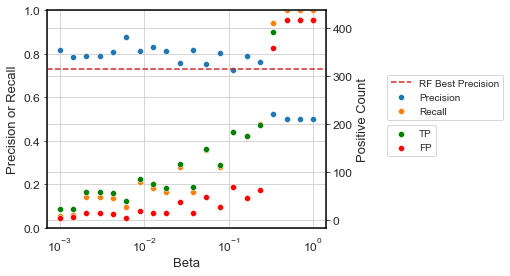

In [184]:
tps = []
fps = []
precisions = []
recalls = []
for beta, beta_result_df in beta_result_dfs.items():
    
    true_beta_result_df = beta_result_df[beta_result_df['y_train'] == 'true']
    tp, fp = true_beta_result_df['val_tp'].mean(), true_beta_result_df['val_fp'].mean()
    tn, fn = true_beta_result_df['val_tn'].mean(), true_beta_result_df['val_fn'].mean()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    tps.append(tp)
    fps.append(fp)
    precisions.append(precision)
    recalls.append(recall)
    
# make a plot showing the TPs and FPs on one axis and precision on another
sns.set_style('whitegrid')
_, ax_prec = plt.subplots(figsize=(5, 4))
sns.scatterplot(x=beta_result_dfs.keys(), y=precisions, label='Precision', ax=ax_prec)
sns.scatterplot(x=beta_result_dfs.keys(), y=recalls, label='Recall', ax=ax_prec)
ax_prec.set_xscale('log')
ax_prec.tick_params(axis='both', labelsize=12)
ax_prec.set_ylim(0, 1)
ax_prec.set_xlabel('Beta', fontsize=13)
ax_prec.set_ylabel('Precision or Recall', fontsize=13)
ax_prec.axhline(0.73, color='tab:red', linestyle='--', label='RF Best Precision')
ax_prec.legend(bbox_to_anchor=(1.2, 0.6), loc='center left');

ax_tpfp = ax_prec.twinx()
sns.scatterplot(x=beta_result_dfs.keys(), y=tps, ax=ax_tpfp, label='TP', color='green')
sns.scatterplot(x=beta_result_dfs.keys(), y=fps, ax=ax_tpfp, label='FP', color='red')
ax_tpfp.tick_params(axis='both', labelsize=12)
ax_tpfp.set_ylabel('Positive Count', fontsize=13)
ax_tpfp.legend(bbox_to_anchor=(1.2, 0.4), loc='center left');
for s in ax_tpfp.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

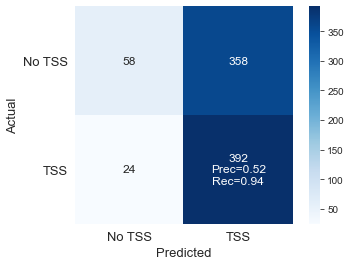

In [151]:
# prepare an average confusion matrix for the 5-fold CV
beta_minus2 = beta_result_dfs[0.3359818286283781]
true_result_df = beta_minus2[beta_minus2['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn, fp],
        [fn, tp]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

annot = conf_mat.copy()
annot = annot.astype(int)
annot = annot.astype(str)
annot.iloc[1, 1] = f'{int(tp)}\nPrec={tp/(tp+fp):.2f}\nRec={tp/(tp+fn):.2f}'
sns.heatmap(conf_mat, cmap='Blues', square=True,
            annot=annot, annot_kws={'fontsize': 12}, fmt='', ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

## Sigma Specific

In [18]:
s70_result_df = run_trial(
    sigma_tss_dfs['Sigma70'],
    n_upstream=50, n_downstream=20, n_negative_per=4,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5
)

Epoch 1/50
271/271 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.5354 - auroc: 0.5504 - auprc: 0.2273 - fn: 402.0000 - fp: 1609.0000 - tn: 1854.0000 - tp: 463.0000 - val_loss: 0.6534 - val_accuracy: 0.6497 - val_auroc: 0.6117 - val_auprc: 0.2739 - val_fn: 125.0000 - val_fp: 254.0000 - val_tn: 611.0000 - val_tp: 92.0000
Epoch 2/50
271/271 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.5776 - auroc: 0.6197 - auprc: 0.2728 - fn: 342.0000 - fp: 1486.0000 - tn: 1977.0000 - tp: 523.0000 - val_loss: 0.7051 - val_accuracy: 0.5102 - val_auroc: 0.6912 - val_auprc: 0.3383 - val_fn: 40.0000 - val_fp: 490.0000 - val_tn: 375.0000 - val_tp: 177.0000
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6124 - accuracy: 0.6647 - auroc: 0.7326 - auprc: 0.3941 - fn: 264.0000 - fp: 1187.0000 - tn: 2276.0000 - tp: 601.0000 - val_loss: 0.5852 - val_accuracy: 0.7043 - val_auroc: 0.7735 - val_auprc: 0.4381 - val_fn: 58.0000 - va

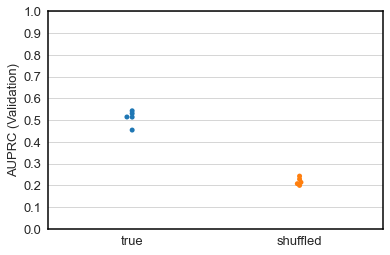

In [19]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=s70_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

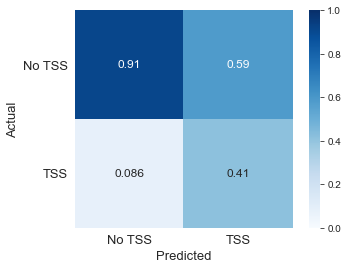

In [20]:
# prepare an average confusion matrix for the 5-fold CV
s70_true_result_df = s70_result_df[s70_result_df['y_train'] == 'true']
fn, fp = s70_true_result_df['val_fn'].mean(), s70_true_result_df['val_fp'].mean()
tn, tp = s70_true_result_df['val_tn'].mean(), s70_true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn / (tn + fn), fp / (fp + tp)],
        [fn / (tn + fn), tp / (fp + tp)]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

sns.heatmap(conf_mat, cmap='Blues', square=True, vmin=0, vmax=1,
            annot=True, annot_kws={'fontsize': 12}, ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

## RegulonDB (HT)

In [21]:
regdb_ht_result_df = run_trial(
    regulondb_tss_ht,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5
)

Epoch 1/50
866/866 [==============================] - 2s 3ms/step - loss: 0.6865 - accuracy: 0.5388 - auroc: 0.5591 - auprc: 0.5544 - fn: 3221.0000 - fp: 3164.0000 - tn: 3758.0000 - tp: 3700.0000 - val_loss: 0.6698 - val_accuracy: 0.5874 - val_auroc: 0.6353 - val_auprc: 0.6178 - val_fn: 1032.0000 - val_fp: 396.0000 - val_tn: 1334.0000 - val_tp: 699.0000
Epoch 2/50
866/866 [==============================] - 2s 2ms/step - loss: 0.6591 - accuracy: 0.6064 - auroc: 0.6474 - auprc: 0.6311 - fn: 2711.0000 - fp: 2737.0000 - tn: 4185.0000 - tp: 4210.0000 - val_loss: 0.6560 - val_accuracy: 0.6099 - val_auroc: 0.6655 - val_auprc: 0.6475 - val_fn: 928.0000 - val_fp: 422.0000 - val_tn: 1308.0000 - val_tp: 803.0000
Epoch 3/50
866/866 [==============================] - 2s 2ms/step - loss: 0.6420 - accuracy: 0.6322 - auroc: 0.6804 - auprc: 0.6617 - fn: 2507.0000 - fp: 2584.0000 - tn: 4338.0000 - tp: 4414.0000 - val_loss: 0.6434 - val_accuracy: 0.6287 - val_auroc: 0.7015 - val_auprc: 0.6913 - val_fn: 3

In [22]:
regdb_ht_result_df

,fold,y_train,train_accuracy,val_accuracy,train_auroc,val_auroc,train_auprc,val_auprc,train_fn,val_fn,train_fp,val_fp,train_tn,val_tn,train_tp,val_tp
0,0,true,0.693347,0.685929,0.761042,0.737265,0.758746,0.737069,2276.0,680.0,1969.0,407.0,4953.0,1323.0,4645.0,1051.0
1,0,shuffled,0.535072,0.515747,0.546833,0.525178,0.531052,0.519236,2997.0,468.0,3439.0,1208.0,3483.0,522.0,3924.0,1263.0
2,1,true,0.696959,0.677839,0.759808,0.743973,0.758117,0.748652,2289.0,637.0,1906.0,478.0,5016.0,1252.0,4632.0,1094.0
3,1,shuffled,0.489923,0.499856,0.491270,0.500000,0.491201,0.500144,3543.0,1731.0,3518.0,0.0,3404.0,1730.0,3378.0,0.0
4,2,true,0.702882,0.672638,0.771635,0.720791,0.762204,0.721292,2165.0,589.0,1948.0,544.0,4973.0,1187.0,4757.0,1141.0
5,2,shuffled,0.499603,0.500144,0.497584,0.500288,0.498285,0.500000,989.0,1730.0,5938.0,0.0,983.0,1731.0,5933.0,0.0
6,3,true,0.692552,0.667148,0.762185,0.722953,0.757649,0.708207,2265.0,655.0,1991.0,497.0,4930.0,1234.0,4657.0,1075.0
7,3,shuffled,0.501914,0.500433,0.498459,0.531716,0.500378,0.527921,4147.0,1724.0,2748.0,5.0,4173.0,1726.0,2775.0,6.0
8,4,true,0.693802,0.677746,0.757324,0.732473,0.757229,0.729474,2317.0,584.0,1922.0,531.0,5000.0,1199.0,4605.0,1146.0
9,4,shuffled,0.498266,0.499133,0.501907,0.502273,0.500630,0.500985,2043.0,1700.0,4903.0,33.0,2019.0,1697.0,4879.0,30.0


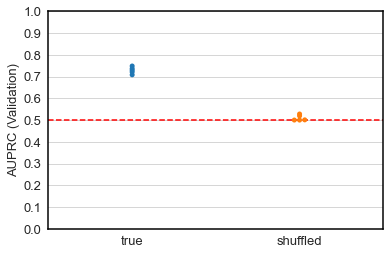

In [23]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=regdb_ht_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.axhline(0.5, linestyle='--', color='r')
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

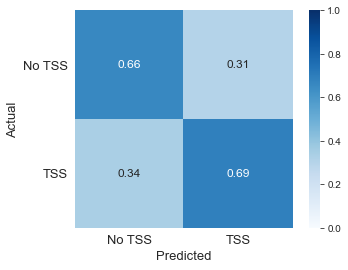

In [24]:
# prepare an average confusion matrix for the 5-fold CV
true_result_df = regdb_ht_result_df[regdb_ht_result_df['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn / (tn + fn), fp / (fp + tp)],
        [fn / (tn + fn), tp / (fp + tp)]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

sns.heatmap(conf_mat, cmap='Blues', square=True, vmin=0, vmax=1,
            annot=True, annot_kws={'fontsize': 12}, ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

## Cho HT

In [152]:
cho_result_df = run_trial(
    cho_tss,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5
)

Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6962 - accuracy: 0.4986 - auroc: 0.4981 - auprc: 0.4976 - fn: 1468.0000 - fp: 1847.0000 - tn: 1459.0000 - tp: 1838.0000 - val_loss: 0.6949 - val_accuracy: 0.4921 - val_auroc: 0.4778 - val_auprc: 0.4893 - val_fn: 679.0000 - val_fp: 161.0000 - val_tn: 666.0000 - val_tp: 148.0000
Epoch 2/50
414/414 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5045 - auroc: 0.5075 - auprc: 0.5025 - fn: 1173.0000 - fp: 2103.0000 - tn: 1203.0000 - tp: 2133.0000 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auroc: 0.5006 - val_auprc: 0.5025 - val_fn: 1.0000 - val_fp: 826.0000 - val_tn: 1.0000 - val_tp: 826.0000
Epoch 3/50
414/414 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5041 - auroc: 0.5027 - auprc: 0.5017 - fn: 409.0000 - fp: 2870.0000 - tn: 436.0000 - tp: 2897.0000 - val_loss: 0.6933 - val_accuracy: 0.4879 - val_auroc: 0.4965 - val_auprc: 0.5033 - val_fn: 101.0000 -

414/414 [==============================] - 1s 2ms/step - loss: 0.6900 - accuracy: 0.5305 - auroc: 0.5475 - auprc: 0.5362 - fn: 1327.0000 - fp: 1778.0000 - tn: 1528.0000 - tp: 1980.0000 - val_loss: 0.6960 - val_accuracy: 0.4955 - val_auroc: 0.4983 - val_auprc: 0.4945 - val_fn: 475.0000 - val_fp: 359.0000 - val_tn: 468.0000 - val_tp: 351.0000
Epoch 7/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6889 - accuracy: 0.5343 - auroc: 0.5525 - auprc: 0.5403 - fn: 1401.0000 - fp: 1679.0000 - tn: 1627.0000 - tp: 1906.0000 - val_loss: 0.6967 - val_accuracy: 0.4943 - val_auroc: 0.5008 - val_auprc: 0.4972 - val_fn: 340.0000 - val_fp: 496.0000 - val_tn: 331.0000 - val_tp: 486.0000
Epoch 8/50
414/414 [==============================] - 1s 2ms/step - loss: 0.6877 - accuracy: 0.5401 - auroc: 0.5587 - auprc: 0.5508 - fn: 1370.0000 - fp: 1671.0000 - tn: 1635.0000 - tp: 1937.0000 - val_loss: 0.6980 - val_accuracy: 0.4967 - val_auroc: 0.4996 - val_auprc: 0.4986 - val_fn: 592.0000 - val_

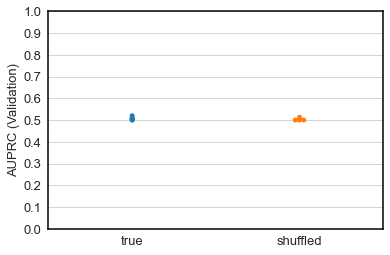

In [153]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=cho_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

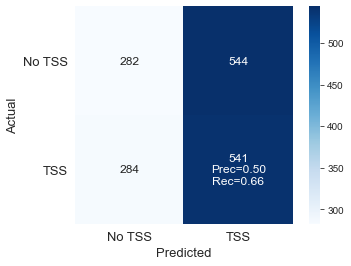

In [154]:
# prepare an average confusion matrix for the 5-fold CV
true_result_df = cho_result_df[cho_result_df['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn, fp],
        [fn, tp]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

annot = conf_mat.copy()
annot = annot.astype(int)
annot = annot.astype(str)
annot.iloc[1, 1] = f'{int(tp)}\nPrec={tp/(tp+fp):.2f}\nRec={tp/(tp+fn):.2f}'
sns.heatmap(conf_mat, cmap='Blues', square=True,
            annot=annot, annot_kws={'fontsize': 12}, fmt='', ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

## Massive Number of Negative Examples

In [29]:
many_neg_result_df = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=100,
    max_upstream_neg=500, max_downstream_neg=500,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5, class_weight={0: 0.5102, 1: 25}
)

Epoch 1/50
10515/10515 [==============================] - 21s 2ms/step - loss: 0.4108 - accuracy: 0.8788 - auroc: 0.7481 - auprc: 0.0299 - fn: 1020.0000 - fp: 19372.0000 - tn: 147188.0000 - tp: 645.0000 - val_loss: 0.2986 - val_accuracy: 0.8813 - val_auroc: 0.8365 - val_auprc: 0.0644 - val_fn: 177.0000 - val_fp: 4814.0000 - val_tn: 36826.0000 - val_tp: 240.0000
Epoch 2/50
10515/10515 [==============================] - 19s 2ms/step - loss: 0.3627 - accuracy: 0.8550 - auroc: 0.8194 - auprc: 0.0517 - fn: 664.0000 - fp: 23734.0000 - tn: 142826.0000 - tp: 1001.0000 - val_loss: 0.3021 - val_accuracy: 0.8810 - val_auroc: 0.8359 - val_auprc: 0.0757 - val_fn: 167.0000 - val_fp: 4839.0000 - val_tn: 36801.0000 - val_tp: 250.0000
Epoch 3/50
10515/10515 [==============================] - 18s 2ms/step - loss: 0.3491 - accuracy: 0.8651 - auroc: 0.8353 - auprc: 0.0641 - fn: 654.0000 - fp: 22035.0000 - tn: 144525.0000 - tp: 1011.0000 - val_loss: 0.2775 - val_accuracy: 0.9149 - val_auroc: 0.8382 - val_a

In [30]:
many_neg_result_df

,fold,y_train,train_accuracy,val_accuracy,train_auroc,val_auroc,train_auprc,val_auprc,train_fn,val_fn,train_fp,val_fp,train_tn,val_tn,train_tp,val_tp
0,0,true,0.875922,0.875597,0.861783,0.835532,0.087978,0.097267,601.0,170.0,20272.0,5062.0,146288.0,36578.0,1064.0,247.0
1,0,shuffled,0.990103,0.990085,0.516956,0.523214,0.010303,0.011380,1665.0,417.0,0.0,0.0,166560.0,41640.0,0.0,0.0
2,1,true,0.896716,0.904368,0.867153,0.842815,0.088514,0.091611,669.0,183.0,16706.0,3839.0,149854.0,37801.0,996.0,234.0
3,1,shuffled,0.990103,0.990085,0.545230,0.524395,0.011412,0.010855,1665.0,417.0,0.0,0.0,166560.0,41640.0,0.0,0.0
4,2,true,0.911619,0.899444,0.887961,0.863563,0.146955,0.121118,608.0,151.0,14260.0,4078.0,152300.0,37562.0,1058.0,265.0
5,2,shuffled,0.989437,0.990108,0.492493,0.477620,0.009556,0.009403,1666.0,416.0,111.0,0.0,166449.0,41640.0,0.0,0.0
6,3,true,0.870757,0.890075,0.872456,0.843760,0.080729,0.083965,521.0,172.0,21221.0,4451.0,145339.0,37189.0,1145.0,244.0
7,3,shuffled,0.989960,0.990108,0.498196,0.572095,0.009858,0.012974,1666.0,416.0,23.0,0.0,166537.0,41640.0,0.0,0.0
8,4,true,0.864813,0.865156,0.868143,0.835413,0.093886,0.091715,528.0,165.0,22214.0,5506.0,144346.0,36134.0,1138.0,251.0
9,4,shuffled,0.988129,0.990108,0.497541,0.427315,0.009910,0.008138,1661.0,416.0,336.0,0.0,166224.0,41640.0,5.0,0.0


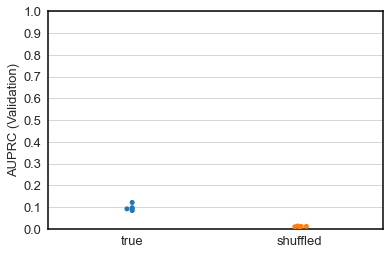

In [31]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=many_neg_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

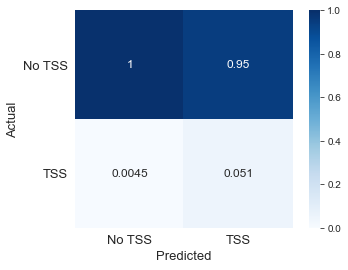

In [32]:
# prepare an average confusion matrix for the 5-fold CV
true_result_df = many_neg_result_df[many_neg_result_df['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn / (tn + fn), fp / (fp + tp)],
        [fn / (tn + fn), tp / (fp + tp)]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

sns.heatmap(conf_mat, cmap='Blues', square=True, vmin=0, vmax=1,
            annot=True, annot_kws={'fontsize': 12}, ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

### With F-beta Loss

In [180]:
negs_fbeta_result_df = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=100,
    max_upstream_neg=200, max_downstream_neg=200,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    beta=0.05,
    batch_size=16, epochs=50, patience=5
)

Epoch 1/50
10515/10515 [==============================] - 21s 2ms/step - loss: 0.9026 - accuracy: 0.9312 - auroc: 0.6267 - auprc: 0.0153 - fn: 1474.0000 - fp: 10097.0000 - tn: 156463.0000 - tp: 191.0000 - val_loss: 0.9665 - val_accuracy: 0.9832 - val_auroc: 0.6369 - val_auprc: 0.0294 - val_fn: 395.0000 - val_fp: 312.0000 - val_tn: 41328.0000 - val_tp: 22.0000
Epoch 2/50
10515/10515 [==============================] - 21s 2ms/step - loss: 0.8578 - accuracy: 0.9648 - auroc: 0.6757 - auprc: 0.0322 - fn: 1394.0000 - fp: 4532.0000 - tn: 162028.0000 - tp: 271.0000 - val_loss: 0.9621 - val_accuracy: 0.9701 - val_auroc: 0.6793 - val_auprc: 0.0405 - val_fn: 337.0000 - val_fp: 921.0000 - val_tn: 40719.0000 - val_tp: 80.0000
Epoch 3/50
10515/10515 [==============================] - 22s 2ms/step - loss: 0.8353 - accuracy: 0.9663 - auroc: 0.6911 - auprc: 0.0420 - fn: 1327.0000 - fp: 4349.0000 - tn: 162211.0000 - tp: 338.0000 - val_loss: 0.9541 - val_accuracy: 0.9619 - val_auroc: 0.7241 - val_auprc: 

In [181]:
negs_fbeta_result_df

,fold,y_train,train_accuracy,val_accuracy,train_auroc,val_auroc,train_auprc,val_auprc,train_fn,val_fn,train_fp,val_fp,train_tn,val_tn,train_tp,val_tp
0,0,true,0.964779,0.952160,0.725894,0.737280,0.058036,0.060955,1216.0,270.0,4709.0,1742.0,161851.0,39898.0,449.0,147.0
1,0,shuffled,0.052971,0.009915,0.483236,0.560656,0.009448,0.012311,79.0,0.0,159235.0,41640.0,7325.0,0.0,1586.0,417.0
2,1,true,0.961706,0.845947,0.671521,0.720750,0.027900,0.033176,1402.0,222.0,5040.0,6257.0,161520.0,35383.0,263.0,195.0
3,1,shuffled,0.945050,0.423092,0.506412,0.491839,0.010250,0.009593,1578.0,179.0,7666.0,24084.0,158894.0,17556.0,87.0,238.0
4,2,true,0.966218,0.981643,0.722080,0.693071,0.056679,0.065807,1251.0,355.0,4432.0,417.0,162128.0,41223.0,415.0,61.0
5,2,shuffled,0.695517,0.983118,0.497685,0.508051,0.010098,0.010471,1174.0,411.0,50048.0,299.0,116512.0,41341.0,492.0,5.0
6,3,true,0.970801,0.981049,0.731960,0.727012,0.072449,0.075435,1208.0,346.0,3704.0,451.0,162856.0,41189.0,458.0,70.0
7,3,shuffled,0.043566,0.009892,0.504789,0.503624,0.010013,0.009829,53.0,0.0,160844.0,41640.0,5716.0,0.0,1613.0,416.0
8,4,true,0.975931,0.975105,0.724690,0.725355,0.070341,0.070287,1308.0,328.0,2741.0,719.0,163819.0,40921.0,358.0,88.0
9,4,shuffled,0.970272,0.936680,0.527388,0.550790,0.011535,0.011502,1607.0,391.0,3394.0,2272.0,163166.0,39368.0,59.0,25.0


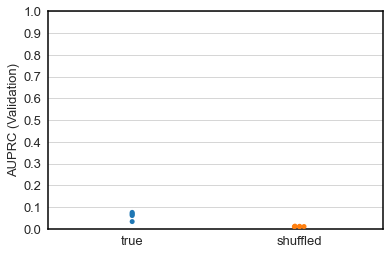

In [182]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.swarmplot(x='y_train', y='val_auprc', data=negs_fbeta_result_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('AUPRC (Validation)', fontsize=13)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

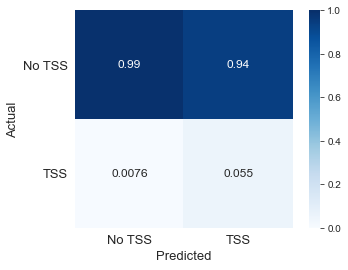

In [183]:
# prepare an average confusion matrix for the 5-fold CV
true_result_df = negs_fbeta_result_df[negs_fbeta_result_df['y_train'] == 'true']
fn, fp = true_result_df['val_fn'].mean(), true_result_df['val_fp'].mean()
tn, tp = true_result_df['val_tn'].mean(), true_result_df['val_tp'].mean()
conf_mat = pd.DataFrame([
        [tn / (tn + fn), fp / (fp + tp)],
        [fn / (tn + fn), tp / (fp + tp)]
    ],
    index=['No TSS', 'TSS'],
    columns=['No TSS', 'TSS']
)

_, ax = plt.subplots()

sns.heatmap(conf_mat, cmap='Blues', square=True, vmin=0, vmax=1,
            annot=True, annot_kws={'fontsize': 12}, ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13);

## Investigating False Negatives

In [155]:
fn_result_df, fn_sample_preds_df = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5,
    return_sample_preds=True
)

Epoch 1/50
209/209 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5078 - auroc: 0.5121 - auprc: 0.5103 - fn: 152.0000 - fp: 1489.0000 - tn: 178.0000 - tp: 1515.0000 - val_loss: 0.6908 - val_accuracy: 0.5444 - val_auroc: 0.5896 - val_auprc: 0.5734 - val_fn: 116.0000 - val_fp: 264.0000 - val_tn: 153.0000 - val_tp: 301.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5417 - auroc: 0.5684 - auprc: 0.5553 - fn: 419.0000 - fp: 1109.0000 - tn: 558.0000 - tp: 1248.0000 - val_loss: 0.6833 - val_accuracy: 0.5899 - val_auroc: 0.6667 - val_auprc: 0.6502 - val_fn: 72.0000 - val_fp: 270.0000 - val_tn: 147.0000 - val_tp: 345.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6778 - accuracy: 0.5810 - auroc: 0.6505 - auprc: 0.6311 - fn: 296.0000 - fp: 1101.0000 - tn: 566.0000 - tp: 1371.0000 - val_loss: 0.6694 - val_accuracy: 0.6427 - val_auroc: 0.7010 - val_auprc: 0.6866 - val_fn: 163.0000 - 

209/209 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7247 - auroc: 0.7923 - auprc: 0.7827 - fn: 457.0000 - fp: 461.0000 - tn: 1206.0000 - tp: 1210.0000 - val_loss: 0.5814 - val_accuracy: 0.7014 - val_auroc: 0.7640 - val_auprc: 0.7657 - val_fn: 124.0000 - val_fp: 125.0000 - val_tn: 292.0000 - val_tp: 293.0000
Epoch 14/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.7289 - auroc: 0.7983 - auprc: 0.7908 - fn: 456.0000 - fp: 448.0000 - tn: 1219.0000 - tp: 1211.0000 - val_loss: 0.5809 - val_accuracy: 0.6918 - val_auroc: 0.7657 - val_auprc: 0.7683 - val_fn: 117.0000 - val_fp: 140.0000 - val_tn: 277.0000 - val_tp: 300.0000
Epoch 15/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5412 - accuracy: 0.7340 - auroc: 0.8032 - auprc: 0.7927 - fn: 452.0000 - fp: 435.0000 - tn: 1232.0000 - tp: 1215.0000 - val_loss: 0.5916 - val_accuracy: 0.6990 - val_auroc: 0.7569 - val_auprc: 0.7526 - val_fn: 126.0000 - val_fp: 

209/209 [==============================] - 0s 2ms/step - loss: 0.5662 - accuracy: 0.7061 - auroc: 0.7791 - auprc: 0.7644 - fn: 483.0000 - fp: 497.0000 - tn: 1171.0000 - tp: 1184.0000 - val_loss: 0.6245 - val_accuracy: 0.6831 - val_auroc: 0.7306 - val_auprc: 0.7326 - val_fn: 167.0000 - val_fp: 97.0000 - val_tn: 319.0000 - val_tp: 250.0000
Epoch 12/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5630 - accuracy: 0.7160 - auroc: 0.7824 - auprc: 0.7645 - fn: 470.0000 - fp: 477.0000 - tn: 1191.0000 - tp: 1197.0000 - val_loss: 0.6175 - val_accuracy: 0.6759 - val_auroc: 0.7310 - val_auprc: 0.7338 - val_fn: 119.0000 - val_fp: 151.0000 - val_tn: 265.0000 - val_tp: 298.0000
Epoch 13/50
209/209 [==============================] - 0s 2ms/step - loss: 0.5601 - accuracy: 0.7109 - auroc: 0.7855 - auprc: 0.7711 - fn: 482.0000 - fp: 482.0000 - tn: 1186.0000 - tp: 1185.0000 - val_loss: 0.6203 - val_accuracy: 0.6687 - val_auroc: 0.7282 - val_auprc: 0.7302 - val_fn: 115.0000 - val_fp: 1

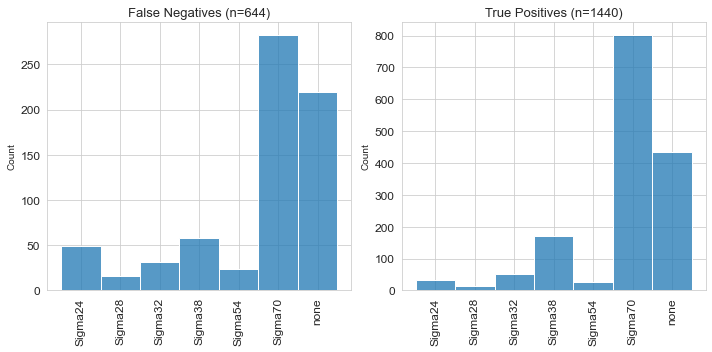

In [160]:
sample_pred_df = fn_sample_preds_df.merge(regulondb_tss, left_on='tss_id', right_index=True, how='left')
sample_pred_df['sigma_factor'] = sample_pred_df['sigma_factor'].fillna(value='none')
sample_pred_df['AT'] = sample_pred_df['sequence'].apply(lambda seq: (seq.count('A') + seq.count('T')) / len(seq))
def conf_mat(row):
    if row['true'] == 1 and row['pred'] >= 0.5:
        return 'tp'
    elif row['true'] == 1 and row['pred'] < 0.5:
        return 'fn'
    elif row['true'] == 0 and row['pred'] >= 0.5:
        return 'fp'
    else:
        return 'tn'
sample_pred_df['conf_mat'] = sample_pred_df.apply(conf_mat, axis=1)

false_negative_df = sample_pred_df[(sample_pred_df['true'] == 1) & (sample_pred_df['pred'] < 0.5)]
fn_sigmas = []
for sigma_raw in false_negative_df['sigma_factor']:
    fn_sigmas.extend([sig.strip() for sig in sigma_raw.split(',')])
    
false_positive_df = sample_pred_df[(sample_pred_df['true'] == 0) & (sample_pred_df['pred'] > 0.5)]
fp_sigmas = []
for sigma_raw in false_positive_df['sigma_factor']:
    fp_sigmas.extend([sig.strip() for sig in sigma_raw.split(',')])

true_positive_df = sample_pred_df[(sample_pred_df['true'] == 1) & (sample_pred_df['pred'] >= 0.5)]
tp_sigmas = []
for sigma_raw in true_positive_df['sigma_factor']:
    tp_sigmas.extend([sig.strip() for sig in sigma_raw.split(',')])

_, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_fn, ax_tp = axs

sns.histplot(sorted(fn_sigmas), ax=ax_fn)
ax_fn.set_title(f'False Negatives (n={false_negative_df.shape[0]})', fontsize=13)

sns.histplot(sorted(tp_sigmas), ax=ax_tp)
ax_tp.set_title(f'True Positives (n={true_positive_df.shape[0]})', fontsize=13)

for ax in axs:
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()

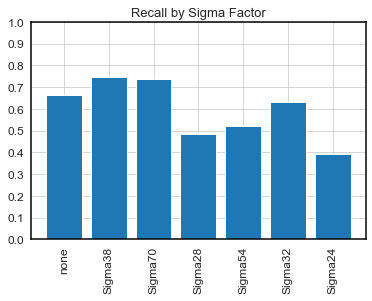

In [182]:
fn_sigma_counts = Counter(fn_sigmas)
tp_sigma_counts = Counter(tp_sigmas)

sigma_recalls = {}
for sigma in fn_sigma_counts.keys():
    sigma_tp = tp_sigma_counts[sigma]
    sigma_fn = fn_sigma_counts[sigma]
    sigma_recalls[sigma] = sigma_tp / (sigma_tp + sigma_fn)
    
sns.set_style('whitegrid')
    
_, ax = plt.subplots()

for i, sigma in enumerate(sigma_recalls.keys()):
    ax.bar(i, sigma_recalls[sigma], color='tab:blue')
    
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(sigma_recalls.keys())
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', rotation=90)
ax.set_title('Recall by Sigma Factor', fontsize=13);
for s in ax.spines.values():
    s.set_linewidth(1.5)
    s.set_color('k')

Text(0, 0.5, 'AT Fraction')

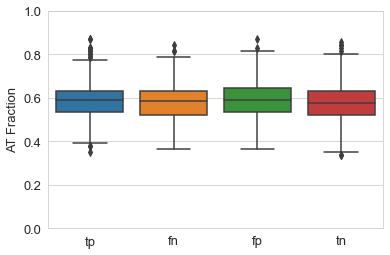

In [142]:
sns.set_style('whitegrid')

_, ax = plt.subplots()

sns.boxplot(x='conf_mat', y='AT', data=sample_pred_df, ax=ax)
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=13)
ax.set_ylabel('AT Fraction', fontsize=13)

## Scoring Across Promoter

In [109]:
prom_score_result_df, prom_score_preds_df, prom_score_model_dict = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5,
    return_sample_preds=True,
    return_models=True
)

Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.6945 - accuracy: 0.5081 - auroc: 0.5209 - auprc: 0.5226 - fn: 821.0000 - fp: 819.0000 - tn: 848.0000 - tp: 846.0000 - val_loss: 0.6866 - val_accuracy: 0.5396 - val_auroc: 0.6089 - val_auprc: 0.6000 - val_fn: 28.0000 - val_fp: 356.0000 - val_tn: 61.0000 - val_tp: 389.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5516 - auroc: 0.5725 - auprc: 0.5579 - fn: 728.0000 - fp: 767.0000 - tn: 900.0000 - tp: 939.0000 - val_loss: 0.6767 - val_accuracy: 0.5911 - val_auroc: 0.6389 - val_auprc: 0.6370 - val_fn: 264.0000 - val_fp: 77.0000 - val_tn: 340.0000 - val_tp: 153.0000
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.5900 - auroc: 0.6308 - auprc: 0.6077 - fn: 717.0000 - fp: 650.0000 - tn: 1017.0000 - tp: 950.0000 - val_loss: 0.6600 - val_accuracy: 0.6091 - val_auroc: 0.6648 - val_auprc: 0.6610 - val_fn: 225.0000 - val_fp:

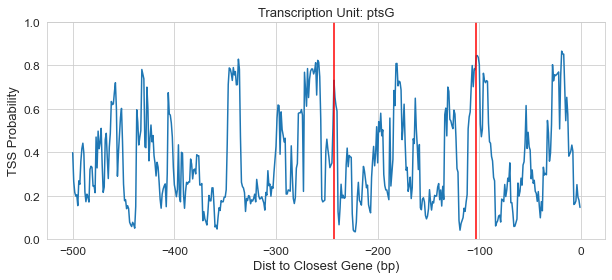

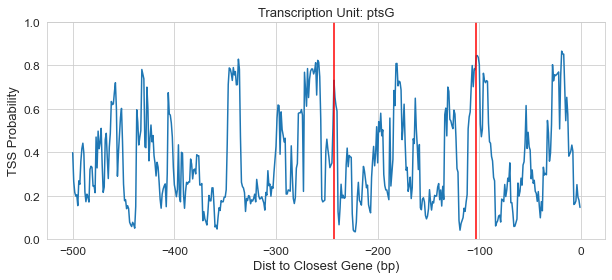

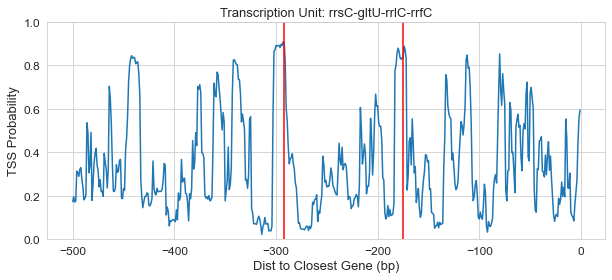

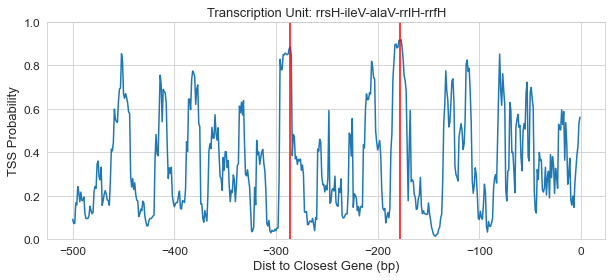

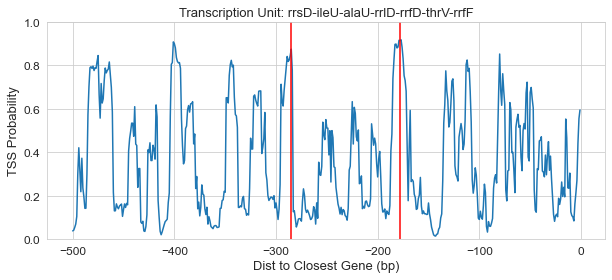

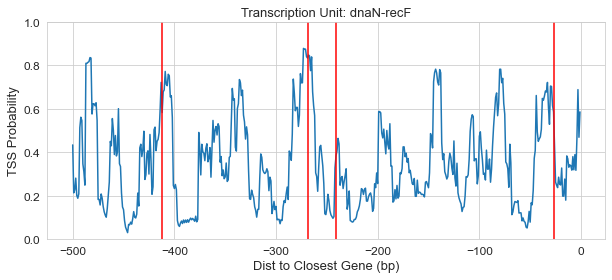

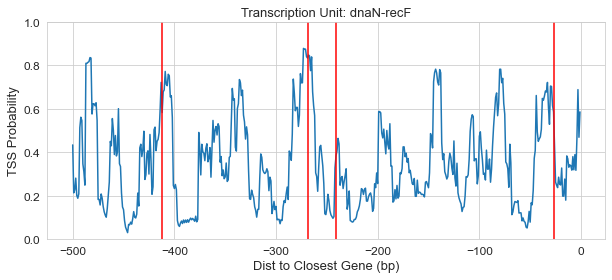

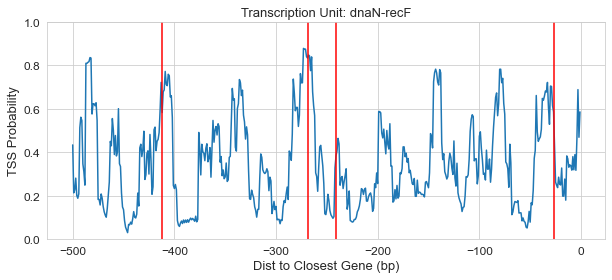

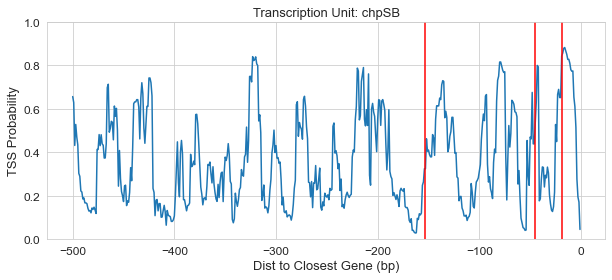

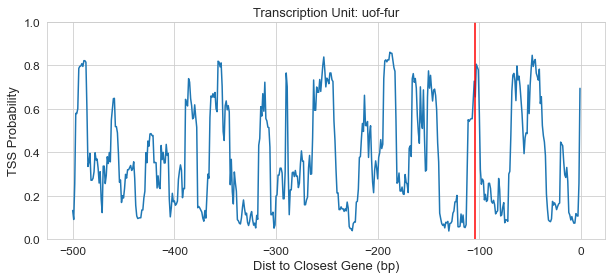

In [132]:
sns.set_style('whitegrid')

N_UP_SWEEP = 500

# now we want to get, for each fold, the model that was trained with that as the validation fold
# then re-evaluate predictions on the validation set by taking a sweep across a full range from the start of the nearest gene to the TSS
for i_fold, fold_trained_model in prom_score_model_dict.items():
    
    # get just the samples from this fold; just the positive samples
    fold_samps_df = prom_score_preds_df[(prom_score_preds_df['fold'] == i_fold) & (prom_score_preds_df['true'] == 1)]
    
    # now for each TSS, we want to get the nearest gene start; generate a sample DF with all positions
    for tss_row in list(fold_samps_df.itertuples())[:10]:
        tu_id = tss_row.tss_id
        genes_for_tu = mg1655._tu_to_genes[tu_id]
        tu_gene_df = mg1655.gene_table.loc[genes_for_tu]
        if tss_row.strand == 1:
            gene_starts = tu_gene_df['left']
        else:
            gene_starts = tu_gene_df['right']
        closest_start = gene_starts[np.argmin(np.abs(np.array(gene_starts) - tss_row.tss))]
        
        # now we can go through each of the positions up to N_UP and create samples
        if tss_row.strand == 1:
            tsses_to_try = np.arange(closest_start - N_UP_SWEEP, closest_start)
        else:
            # flip so that the beginning is always upstream
            tsses_to_try = np.flip(np.arange(closest_start + 1, closest_start + N_UP_SWEEP + 1))
        tss_sweep_rows = []
        for tss_to_try in tsses_to_try:
            tss_seq = get_tss_sequence(tss_to_try, tss_row.strand, 50, 20)
            # determine the label - maybe we have other tss in this range, so just go back to full dataset
            if tss_to_try in list(regulondb_tss['tss']):
                label = 1
                tss_id = tu_id
            else:
                label = 0
                tss_id = f'{tu_id}_neg_{tss_to_try}'
            # add a row to our running DataFrame row list
            tss_sweep_rows.append({
                'tss_id': tss_id,
                'tss': tss_to_try,
                'strand': tss_row.strand,
                'sequence': tss_seq,
                'label': label
            })
        # create the DF of sequences for all the positions upstream of this gene 
        tss_sweep_df = pd.DataFrame(tss_sweep_rows)

        # create a CNN-ready dataset using a helper function; TODO don't hardcode seq length
        tss_sweep_data_array = create_tss_data_array(tss_sweep_df, 71)
        
        # now we can pass this to our model to get predictions
        y_predict = fold_trained_model.predict(tss_sweep_data_array).flatten()
        
        _, ax = plt.subplots(figsize=(10, 4))

        # now we can plot our predictions relative to the TSS
        sns.lineplot(x=np.arange(-N_UP_SWEEP, 0), y=y_predict, ax=ax)
        ax.set_title(f"Transcription Unit: {mg1655.tu_table.loc[tu_id]['name']}", fontsize=13)
        ax.tick_params(axis='both', labelsize=12)
        #ax.set_xticks(np.arange(-500, 50, 50))
        ax.set_xlabel('Dist to Closest Gene (bp)', fontsize=13)
        ax.set_ylabel('TSS Probability', fontsize=13)
        ax.set_ylim(0, 1)

        for real_tss in [i - N_UP_SWEEP for i, tss_to_try in enumerate(tsses_to_try) if tss_to_try in list(regulondb_tss['tss'])]:
            ax.axvline(real_tss, color='red')
        
    break

## Feature Importance

https://stackoverflow.com/questions/46828476/how-to-visualize-output-of-intermediate-layers-of-convolutional-neural-network-i

In [163]:
shap_values, X_val, y_val = run_trial(
    regulondb_tss,
    n_upstream=50, n_downstream=20, n_negative_per=1,
    n_filters=8, filter_size=6, stride=1,
    pool_size=12, pool_stride=12,
    n_neurons=(64, 8), dropout_rate=(0.01, 0.01),
    batch_size=16, epochs=50, patience=5,
    plot_shapley=True
)

Epoch 1/50
209/209 [==============================] - 1s 6ms/step - loss: 0.6944 - accuracy: 0.5120 - auroc: 0.5189 - auprc: 0.5134 - fn: 770.0000 - fp: 857.0000 - tn: 810.0000 - tp: 897.0000 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_auroc: 0.5486 - val_auprc: 0.5401 - val_fn: 416.0000 - val_fp: 1.0000 - val_tn: 416.0000 - val_tp: 1.0000
Epoch 2/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5378 - auroc: 0.5473 - auprc: 0.5405 - fn: 808.0000 - fp: 733.0000 - tn: 934.0000 - tp: 859.0000 - val_loss: 0.7081 - val_accuracy: 0.4988 - val_auroc: 0.5594 - val_auprc: 0.5466 - val_fn: 417.0000 - val_fp: 1.0000 - val_tn: 416.0000 - val_tp: 0.0000e+00
Epoch 3/50
209/209 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5450 - auroc: 0.5536 - auprc: 0.5496 - fn: 803.0000 - fp: 714.0000 - tn: 953.0000 - tp: 864.0000 - val_loss: 0.6846 - val_accuracy: 0.5492 - val_auroc: 0.6066 - val_auprc: 0.5886 - val_fn: 327.0000 - val_fp: 4

Text(0.5, 1.0, 'Real TSS')

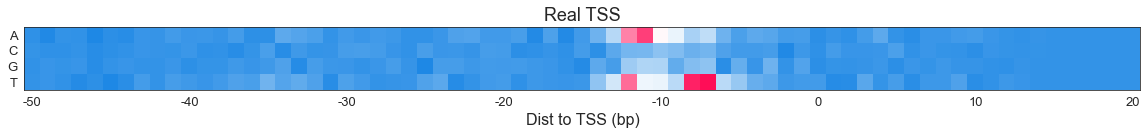

In [197]:
shap_values_arr = np.array(shap_values)[0, :, :, :]
pos_shap_values = shap_values_arr[y_val == 1]
average_pos_shap = pos_shap_values.mean(axis=0)

sns.set_style('white')

_, ax = plt.subplots(figsize=(20, 2))

ax.imshow(average_pos_shap.T, cmap=red_transparent_blue)

ax.set_yticks(np.arange(4))
ax.set_yticklabels(list('ACGT'))
ax.set_xticks(np.arange(0, 80, 10));
ax.set_xticklabels(np.arange(-50, 30, 10));
ax.set_xlabel('Dist to TSS (bp)', fontsize=16);
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Real TSS', fontsize=18)

Text(0.5, 1.0, 'Negative TSS')

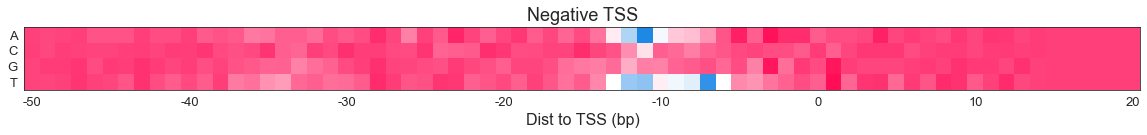

In [198]:
shap_values_arr = np.array(shap_values)[0, :, :, :]
neg_shap_values = shap_values_arr[y_val == 0]
average_neg_shap = neg_shap_values.mean(axis=0)

sns.set_style('white')

_, ax = plt.subplots(figsize=(20, 2))

ax.imshow(average_neg_shap.T, cmap=red_transparent_blue)

ax.set_yticks(np.arange(4))
ax.set_yticklabels(list('ACGT'))
ax.set_xticks(np.arange(0, 80, 10));
ax.set_xticklabels(np.arange(-50, 30, 10));
ax.set_xlabel('Dist to TSS (bp)', fontsize=16);
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Negative TSS', fontsize=18)

# Hyperopt

We want to be able to define a hyperparameter lookup that controls all the behavior of the pipeline

In [343]:
def cnn_hyperopt_random(tss_df, param_space_dict, n_trials=25):
    
    # keep a running list of all our trial results
    trial_result_dfs = []
    
    # for each of our random trials, choose a random combination of the parameters provided
    for i_trial in range(n_trials):
        
        # for each of the params in the range dict, choose a random one
        trial_param_dict = {}
        for param_name, param_options in param_space_dict.items():
            # may have single values in the list or multiple options
            if isinstance(param_options[0], tuple):
                trial_param_dict[param_name] = param_options[np.random.choice(np.arange(len(param_options)))]
            else:
                trial_param_dict[param_name] = np.random.choice(param_options)
        
        # call the single trial function; using this syntax lets us define a subset of the params and leave others default
        print(f'Trial {i_trial+1}/{n_trials}')
        print(trial_param_dict)
        trial_result_df = run_trial(tss_df, **trial_param_dict)
        
        # add metadata to the trial result DF
        trial_result_df['random_trial'] = i_trial
        for param_name, param_val in trial_param_dict.items():
            trial_result_df[param_name] = [param_val for i in range(trial_result_df.shape[0])]
        
        trial_result_dfs.append(trial_result_df)
            
    # assemble a final mega DF
    full_result_df = pd.concat(trial_result_dfs)
    return full_result_df

In [344]:
hyperopt_result_df = cnn_hyperopt_random(
    regulondb_tss,
    {
        'n_upstream': [200, 100, 50],
        'n_downstream': [10, 50],
        'n_negative_per': [2, 5],
        'n_filters': [(32,), (16, ), (8, )],
        'filter_size': [(6, )],
        'stride': [(1, )],
        'pool_size': [(12, )],
        'pool_stride': [(12, )],
        'n_neurons': [(64, 16), (64, 8)],
        'batch_size': [32, 16],
        'epochs': [50]
    },
    n_trials=50
)

Trial 1/50
{'n_upstream': 50, 'n_downstream': 50, 'n_negative_per': 2, 'n_filters': (32,), 'filter_size': (6,), 'stride': (1,), 'pool_size': (12,), 'pool_stride': (12,), 'n_neurons': (64, 8), 'batch_size': 32, 'epochs': 50}
Epoch 1/50
157/157 [==============================] - 1s 7ms/step - loss: 0.6946 - accuracy: 0.4945 - auroc: 0.4947 - auprc: 0.3326 - fn: 866.0000 - fp: 1662.0000 - tn: 1672.0000 - tp: 801.0000 - val_loss: 0.6939 - val_accuracy: 0.3333 - val_auroc: 0.5135 - val_auprc: 0.3512 - val_fn: 0.0000e+00 - val_fp: 834.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 2/50
157/157 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.3665 - auroc: 0.5005 - auprc: 0.3366 - fn: 209.0000 - fp: 2959.0000 - tn: 375.0000 - tp: 1458.0000 - val_loss: 0.6936 - val_accuracy: 0.3333 - val_auroc: 0.5000 - val_auprc: 0.3333 - val_fn: 0.0000e+00 - val_fp: 834.0000 - val_tn: 0.0000e+00 - val_tp: 417.0000
Epoch 3/50
157/157 [==============================] - 0s 3ms/ste

ValueError: could not broadcast input array from shape (0,4) into shape (151,4)